<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
- 1a. Perform any cleaning, feature engineering, and EDA you deem necessary.
- 1b. Be sure to remove any houses that are not residential from the dataset.
- 1c. Identify **fixed** features that can predict price.
- 1d. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- 1e. Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load the data
df = pd.read_csv('housing.csv')
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]


**1a**. Perform any cleaning, feature engineering, and EDA you deem necessary.

### Data cleaning:

---
**1b**. Be sure to remove any houses that are not residential from the dataset.

In [3]:
# remove non-residential rows from dataset

df = df[df['MSZoning'] != 'C (all)']
df['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [5]:
# replace null values in categorical columns with 'none'

null_val_col = ['Alley','BsmtQual','BsmtExposure','GarageType',\
                'MiscFeature','MasVnrType','BsmtCond','BsmtFinType1',\
                'BsmtFinType2','Electrical','FireplaceQu',\
                'GarageFinish','GarageQual','GarageCond','PoolQC','Fence']

for i in null_val_col:
    df[i].fillna(value='none',inplace=True)
    print('Null count for {}: '.format(i), df[i].isnull().sum())

Null count for Alley:  0
Null count for BsmtQual:  0
Null count for BsmtExposure:  0
Null count for GarageType:  0
Null count for MiscFeature:  0
Null count for MasVnrType:  0
Null count for BsmtCond:  0
Null count for BsmtFinType1:  0
Null count for BsmtFinType2:  0
Null count for Electrical:  0
Null count for FireplaceQu:  0
Null count for GarageFinish:  0
Null count for GarageQual:  0
Null count for GarageCond:  0
Null count for PoolQC:  0
Null count for Fence:  0


In [6]:
# replace null values in float columns with '0.0'
    
null_floats = ['GarageYrBlt','LotFrontage','MasVnrArea']

for i in null_floats:
    df[i].fillna(value=0.0, inplace=True)
    print('Null count for {}: '.format(i), df[i].isnull().sum())
    print('dtype for {} :'.format(i), df[i].dtype)

Null count for GarageYrBlt:  0
dtype for GarageYrBlt : float64
Null count for LotFrontage:  0
dtype for LotFrontage : float64
Null count for MasVnrArea:  0
dtype for MasVnrArea : float64


In [7]:
# check if any null values still in dataset

df.isnull().sum().sum()

0

---
### Visualization

In [8]:
# segregate by datatype into diff dataframes

type_object = df.select_dtypes(include='object')
type_integer = df.select_dtypes(include='int')
type_float = df.select_dtypes(include='float')

print(type_object.columns)
print(type_integer.columns)
print(type_float.columns)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd

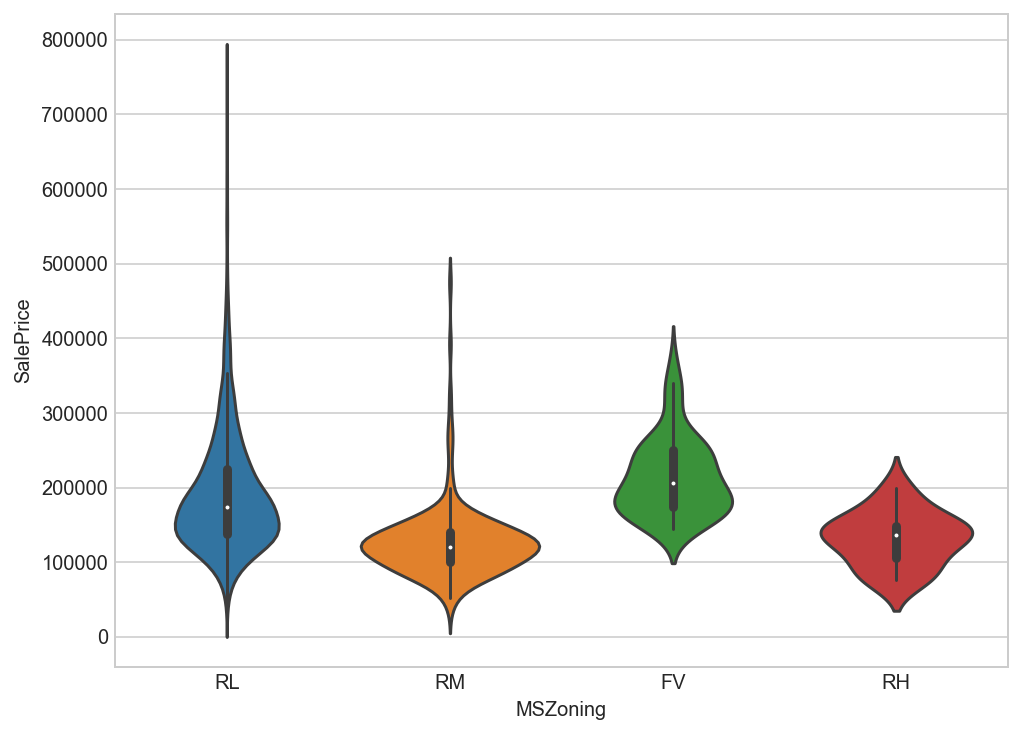

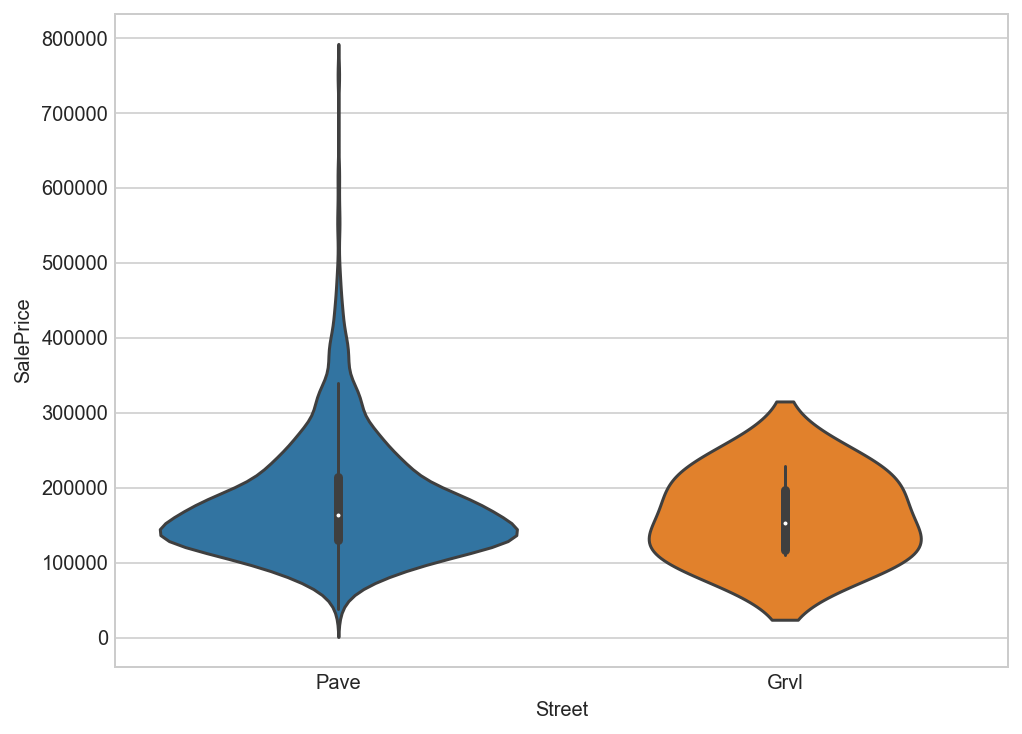

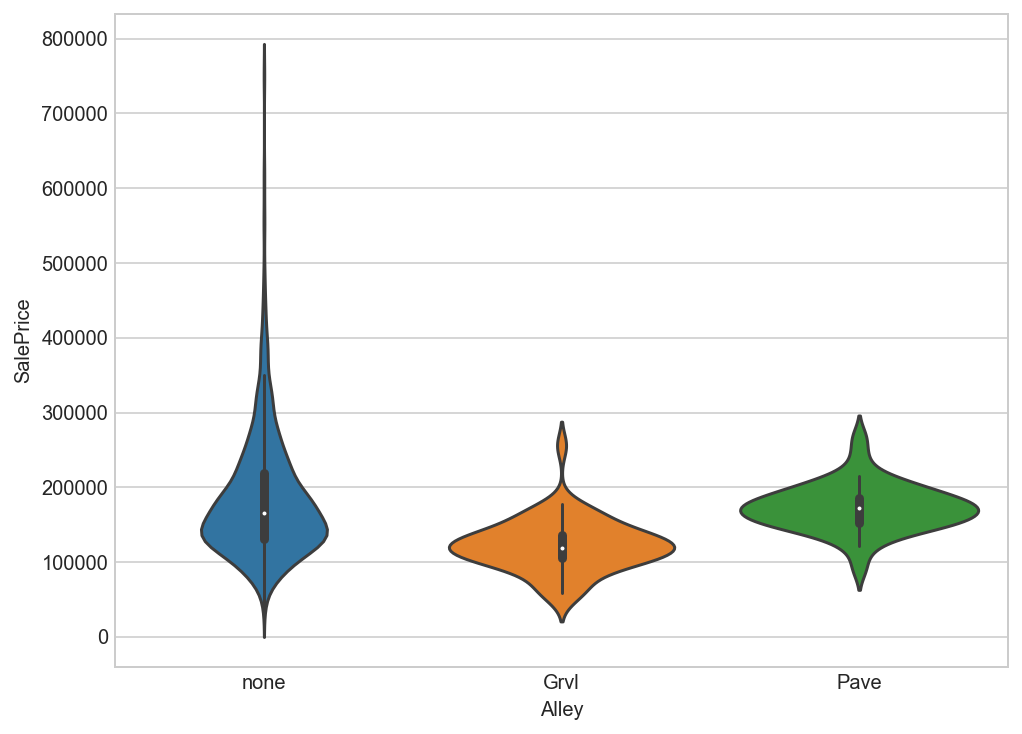

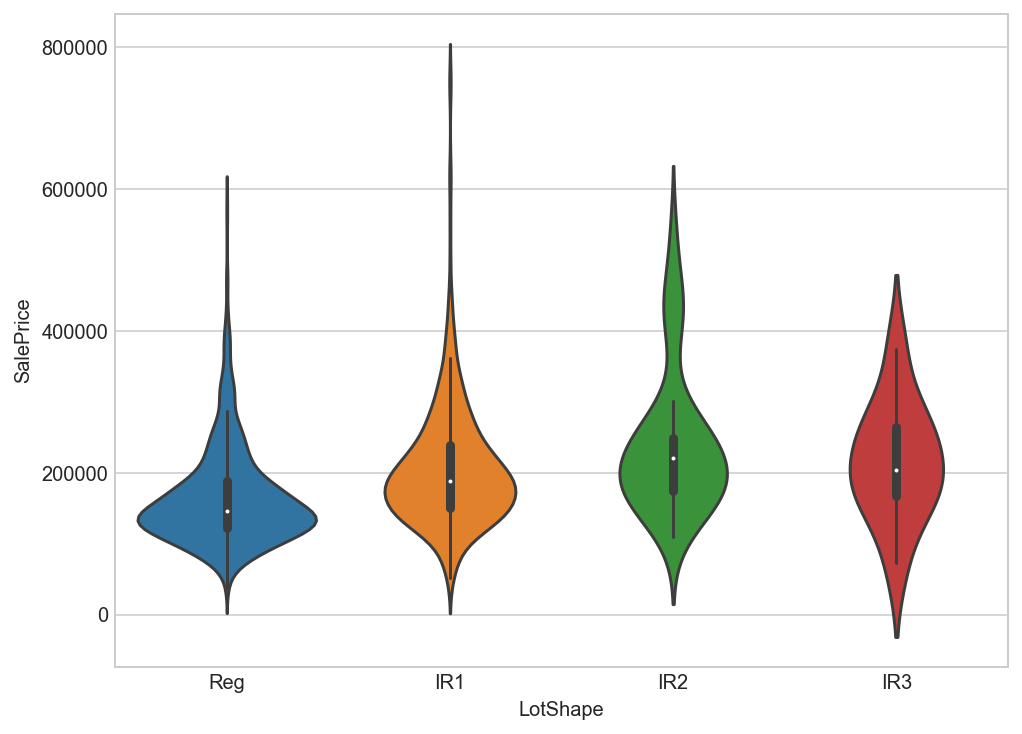

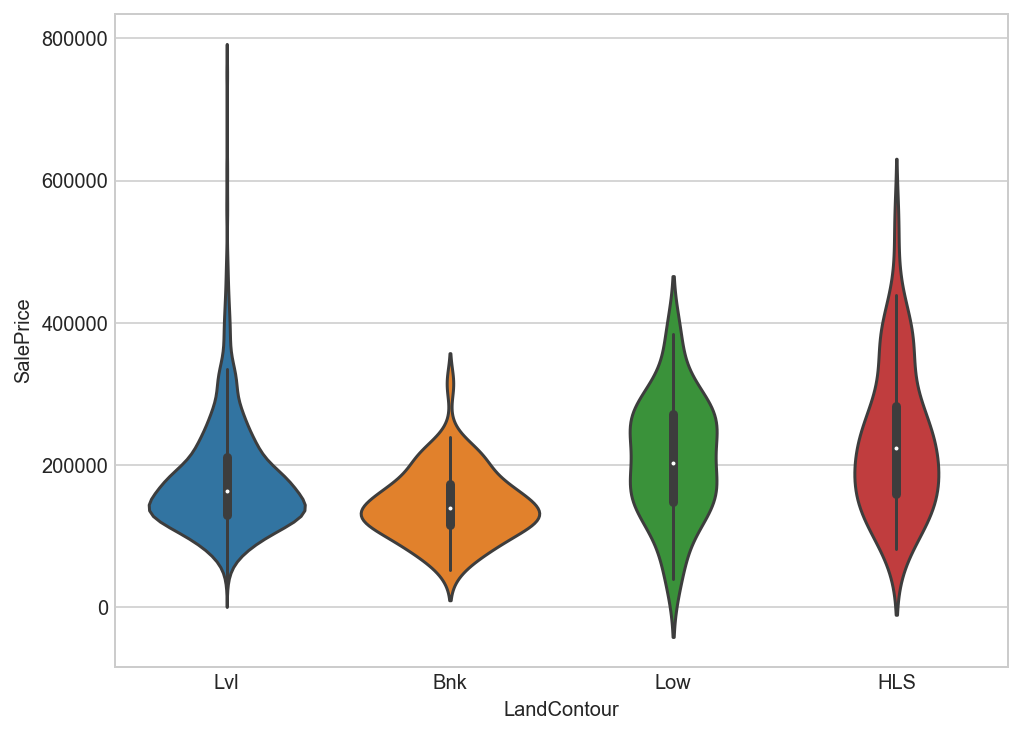

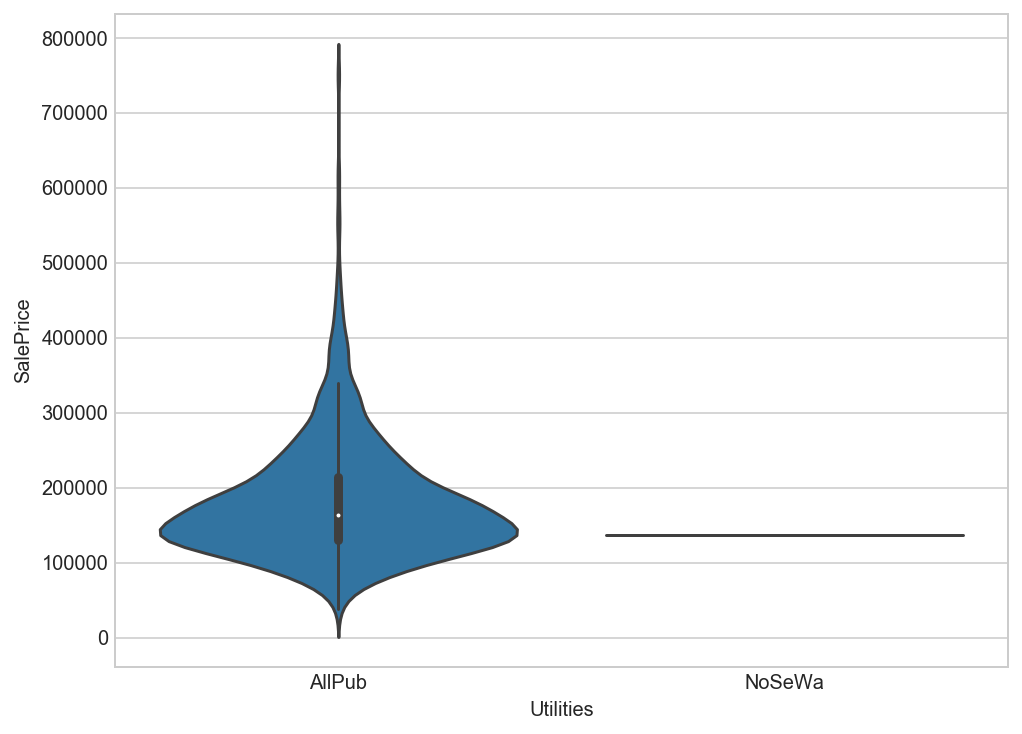

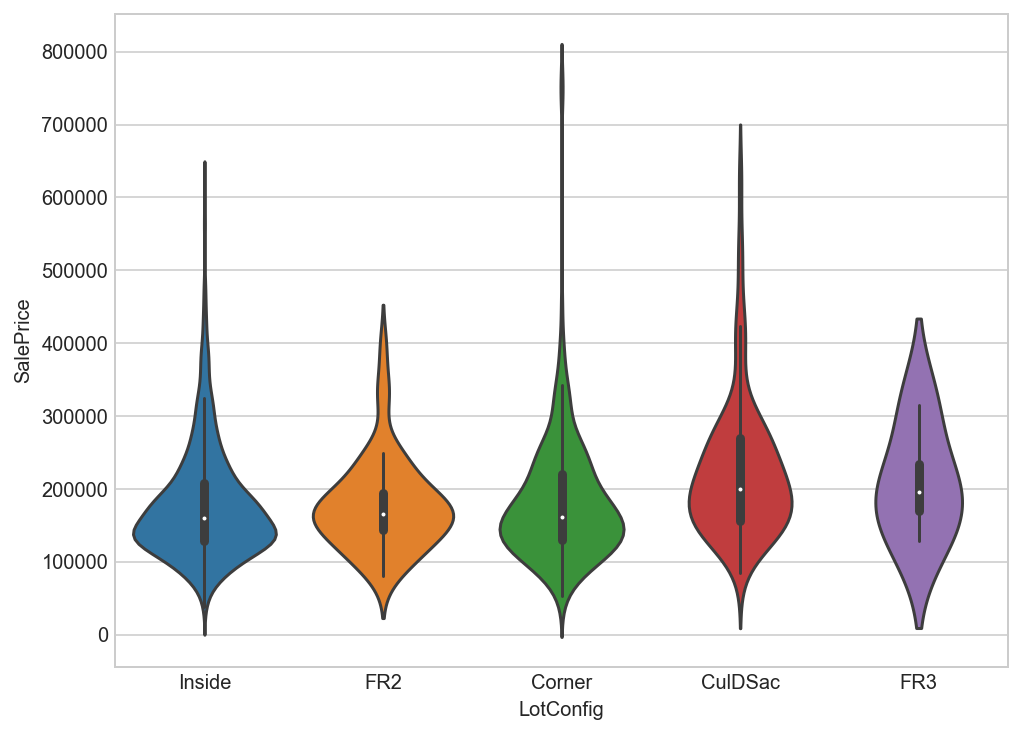

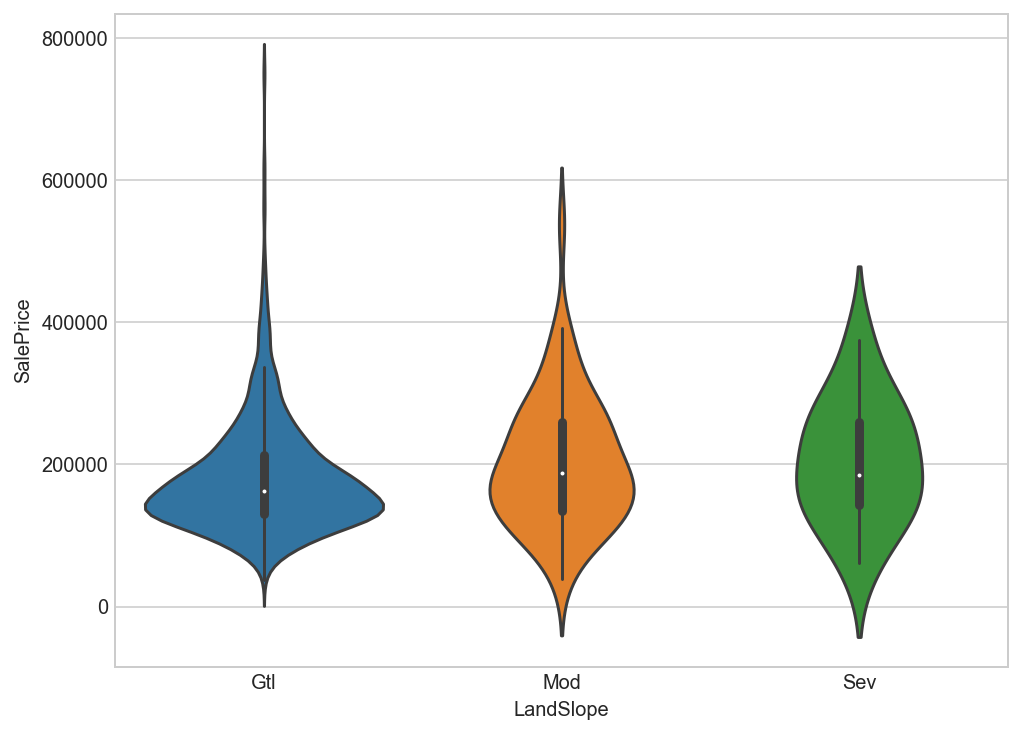

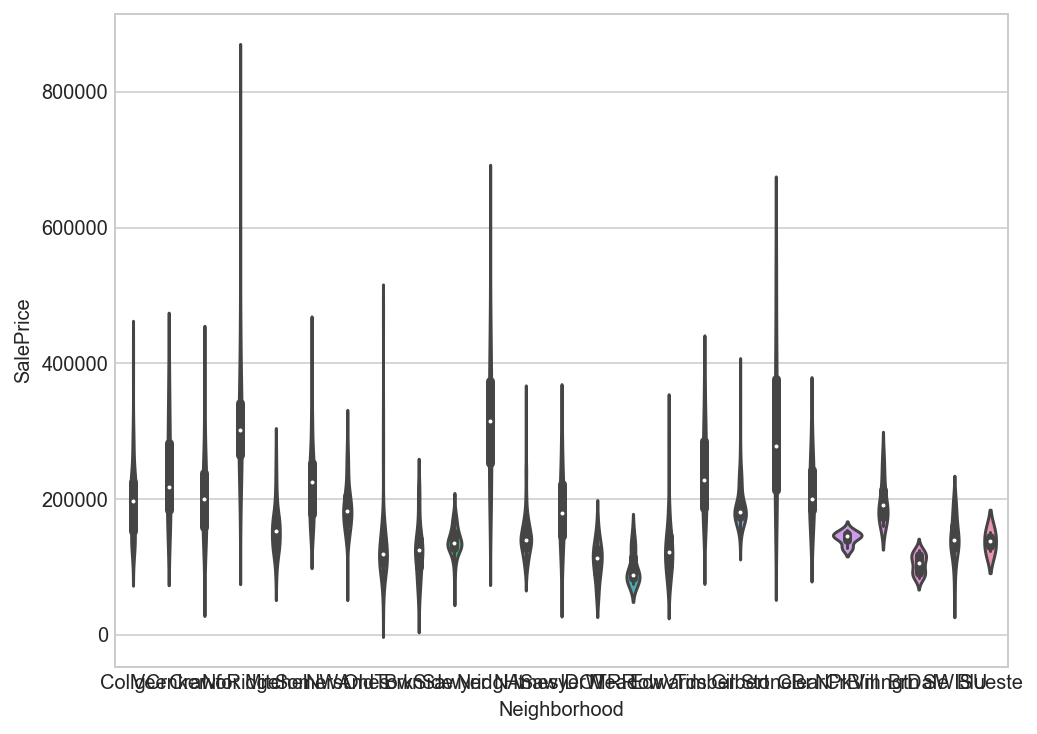

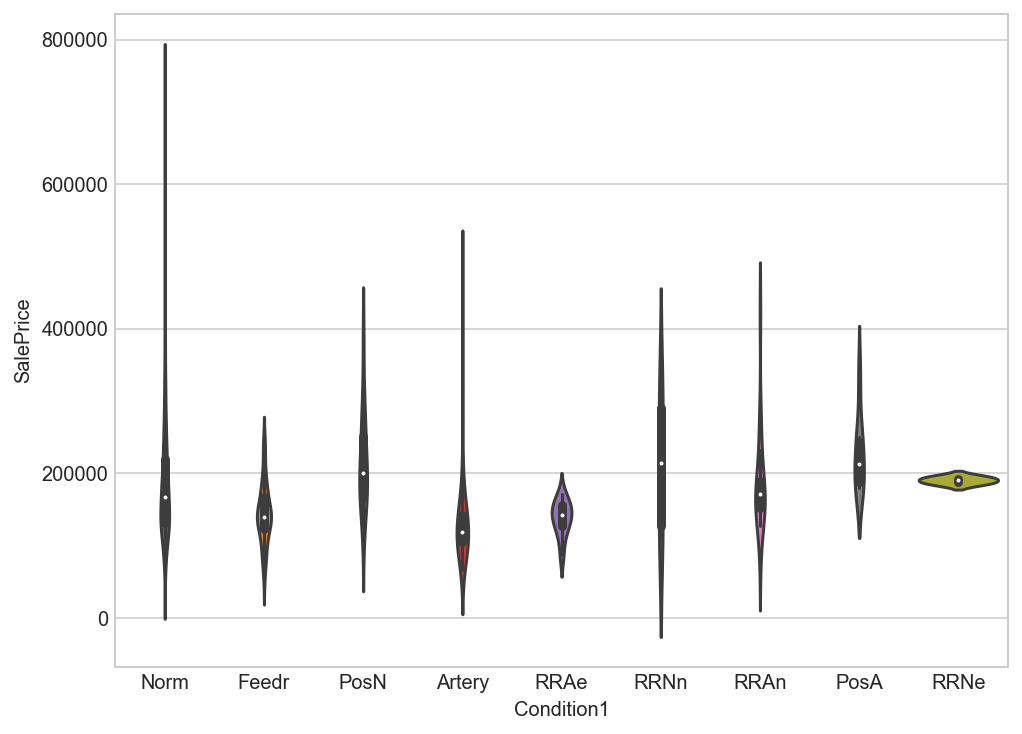

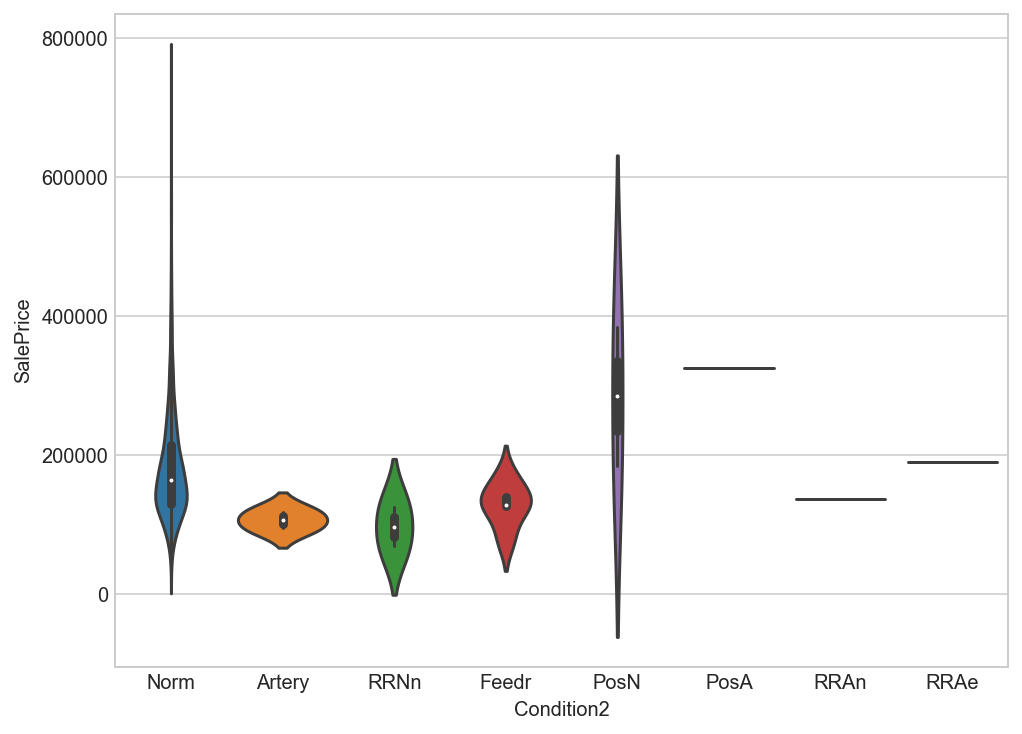

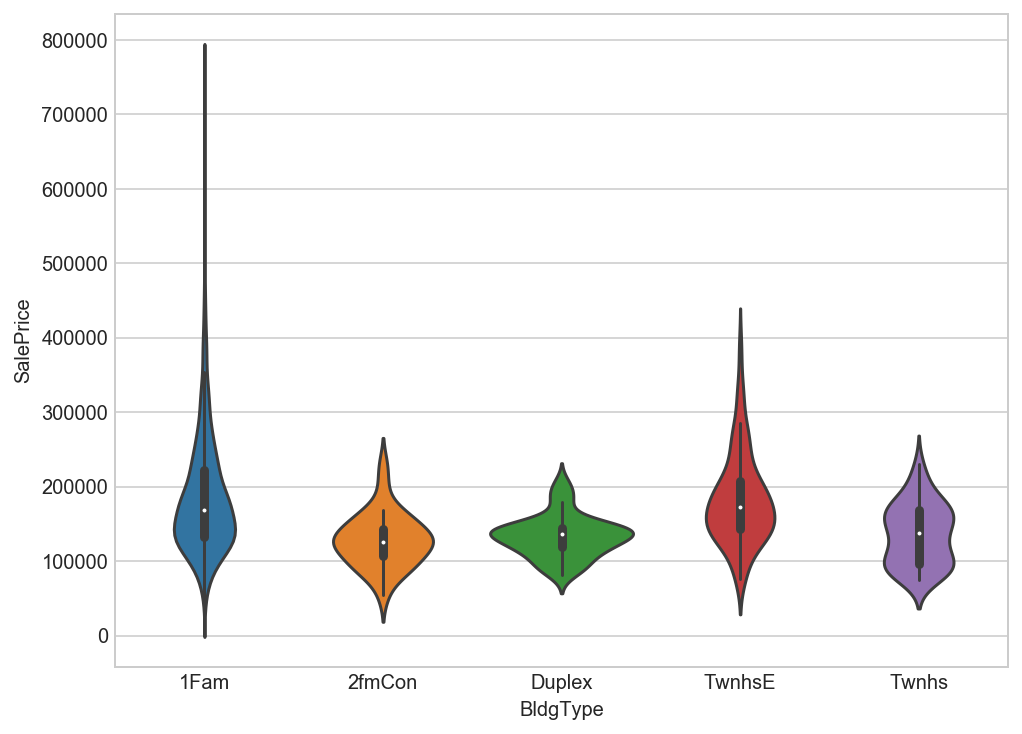

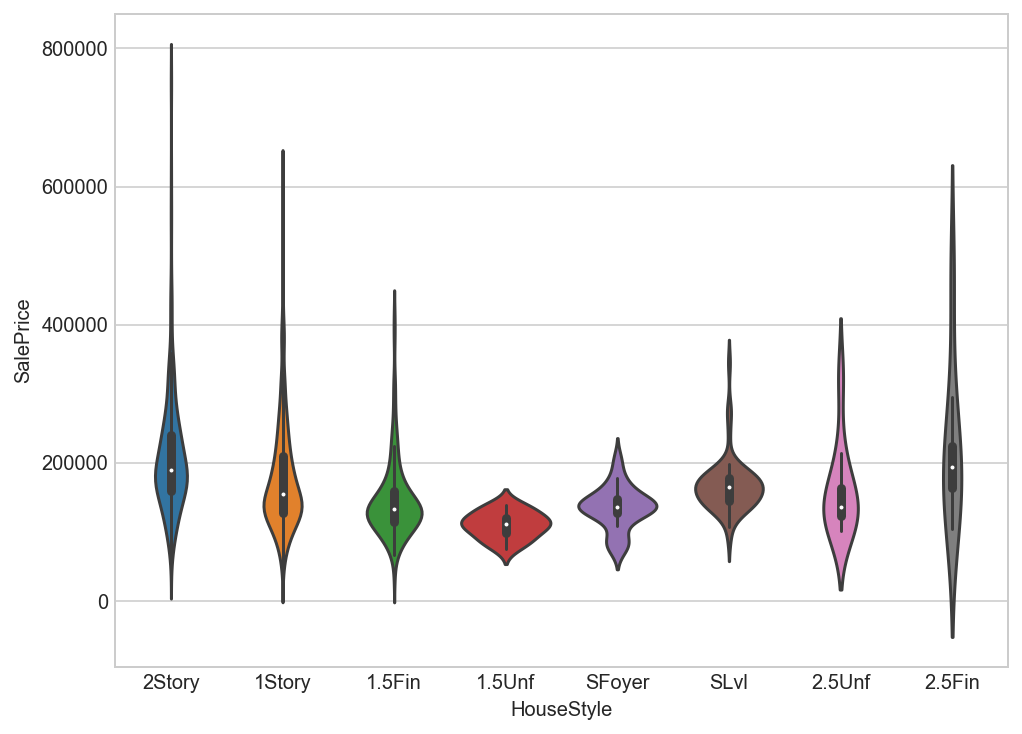

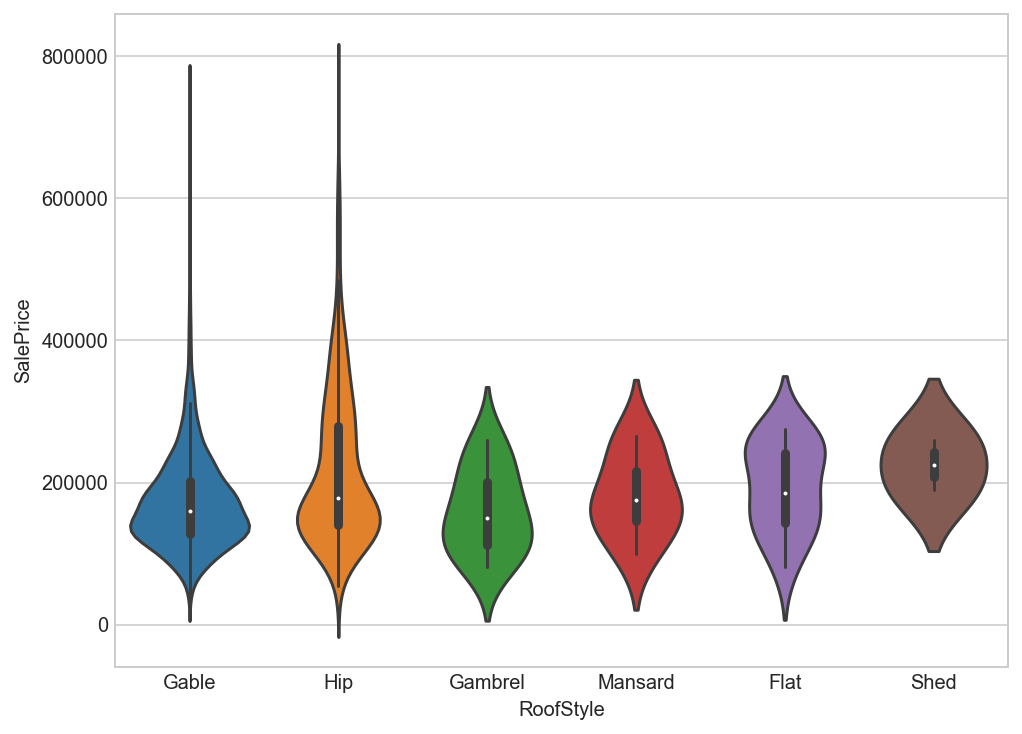

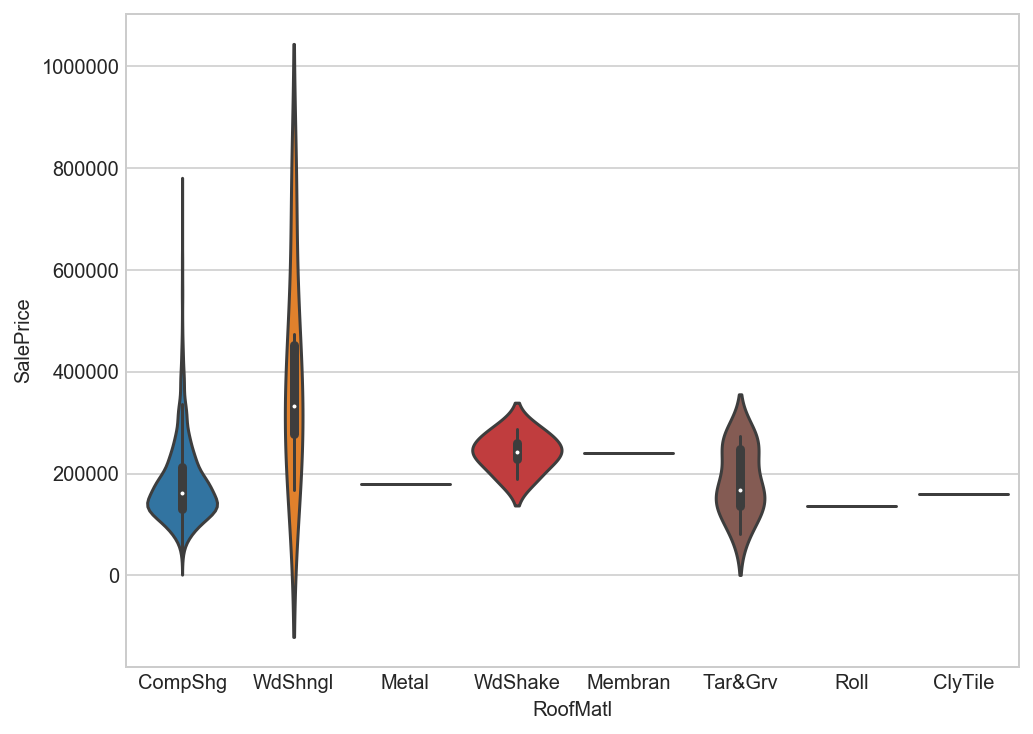

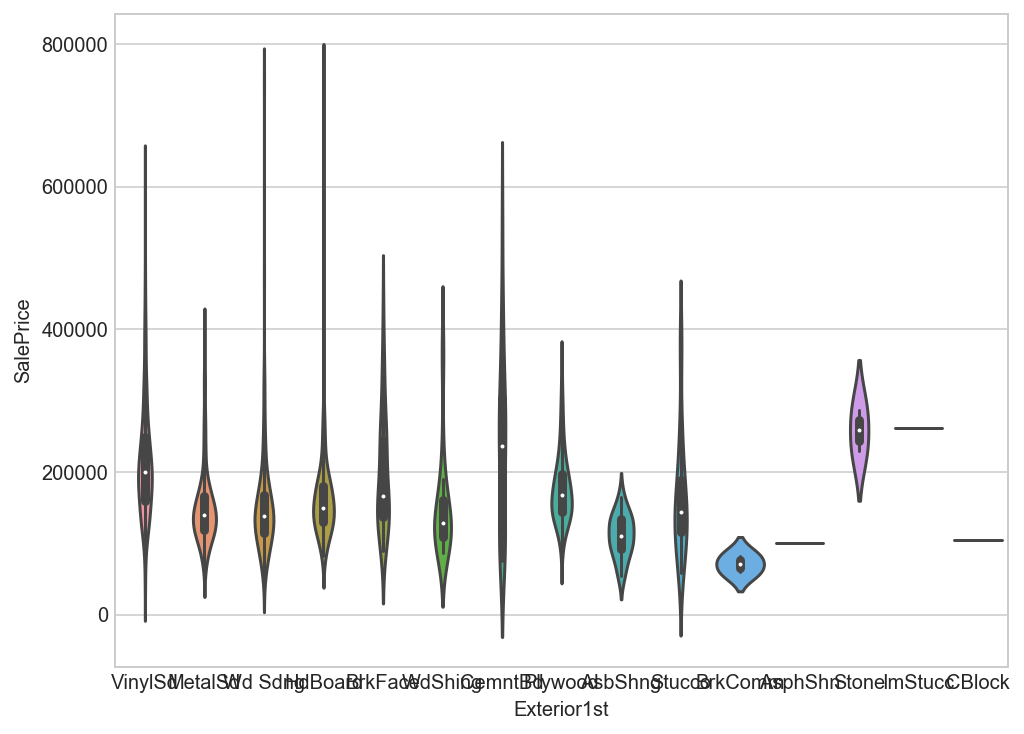

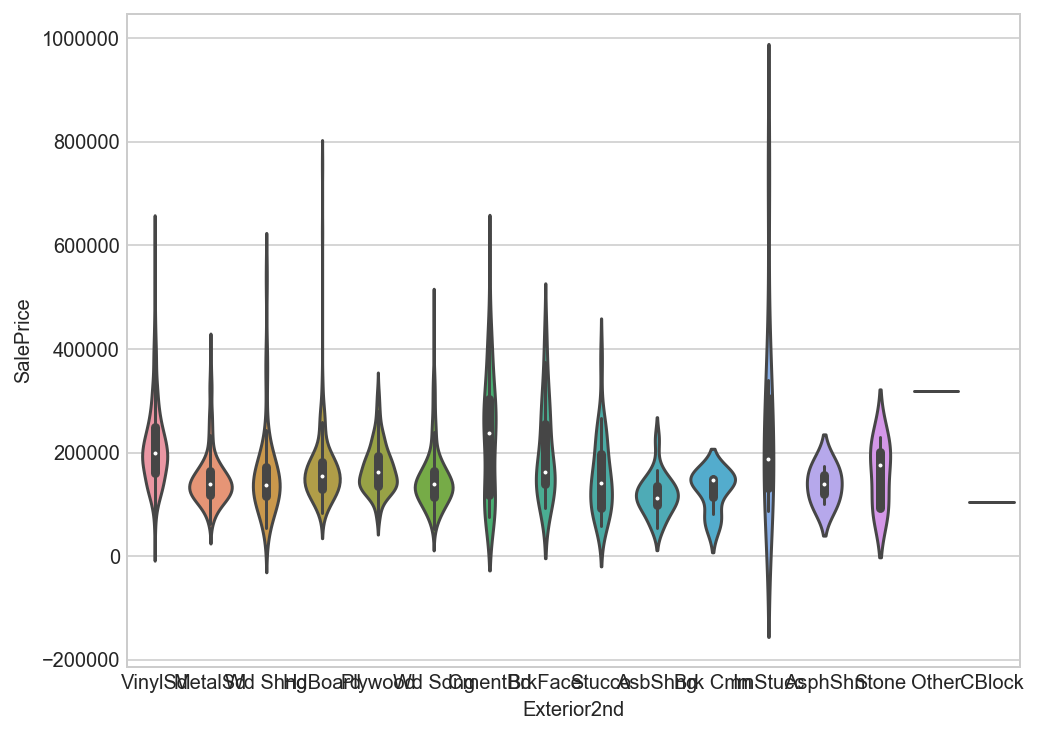

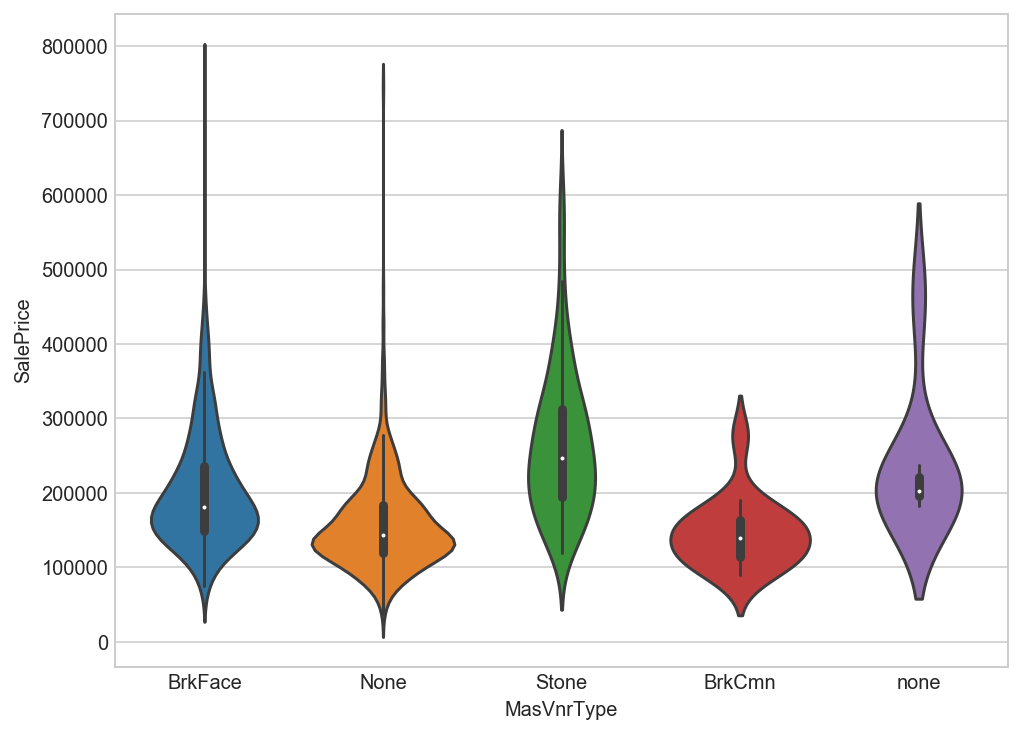

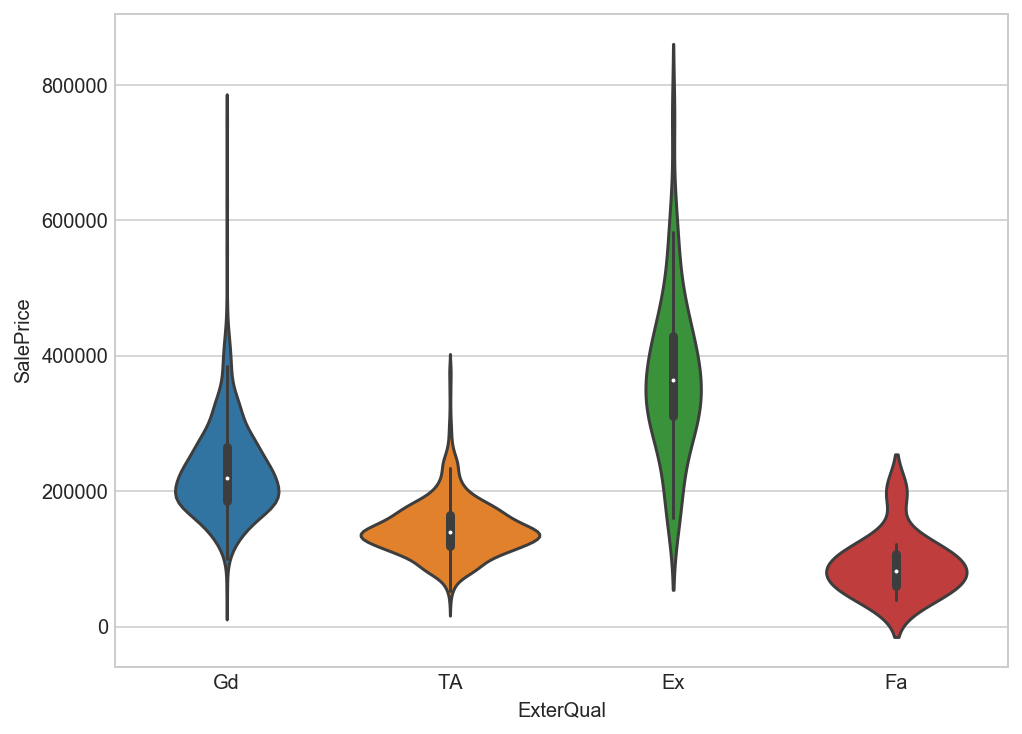

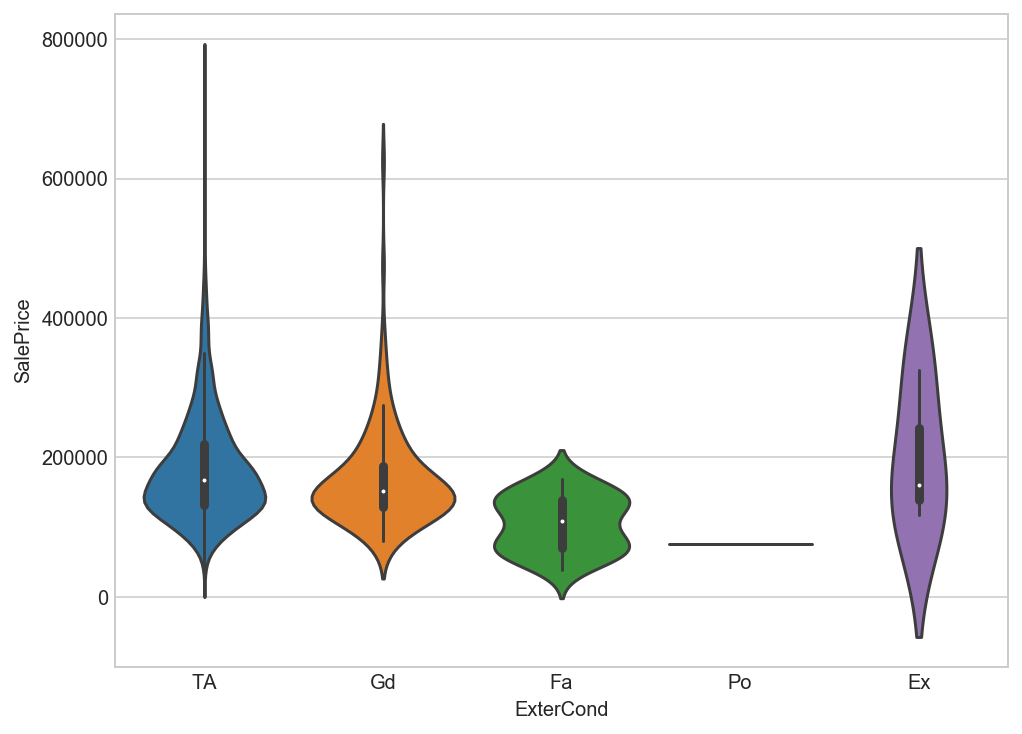

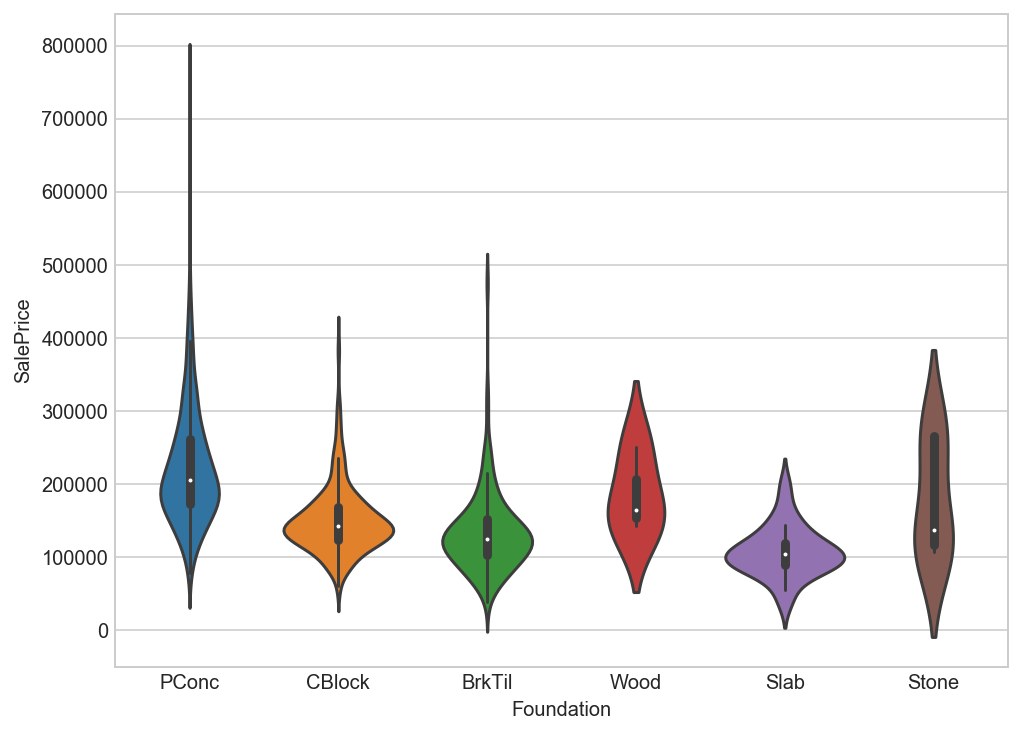

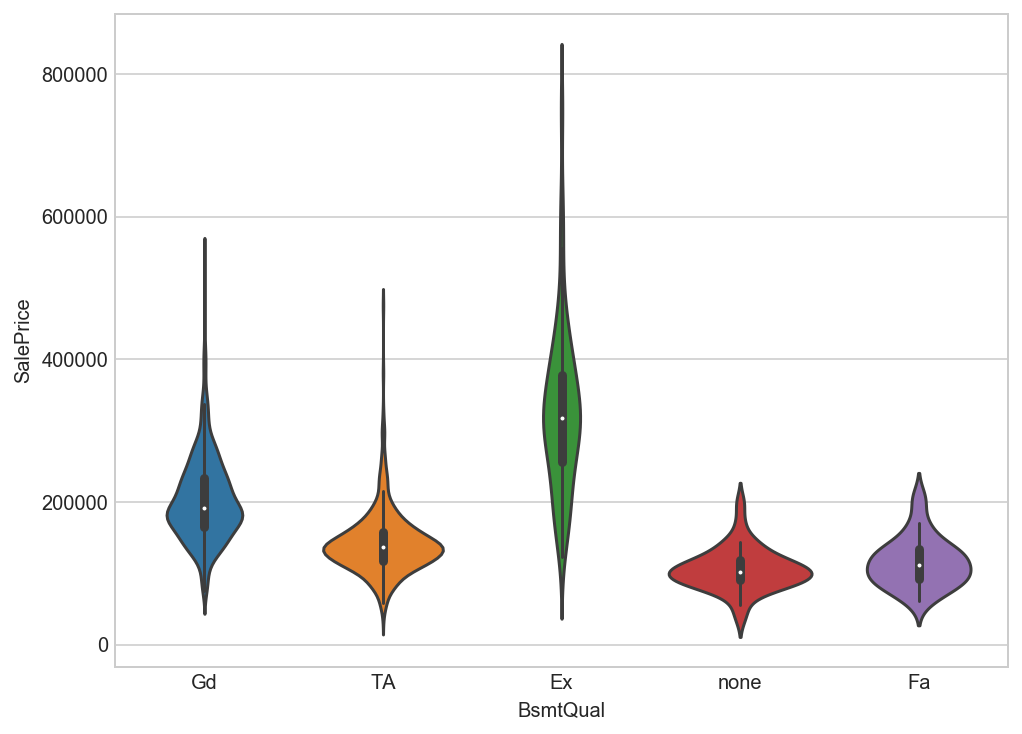

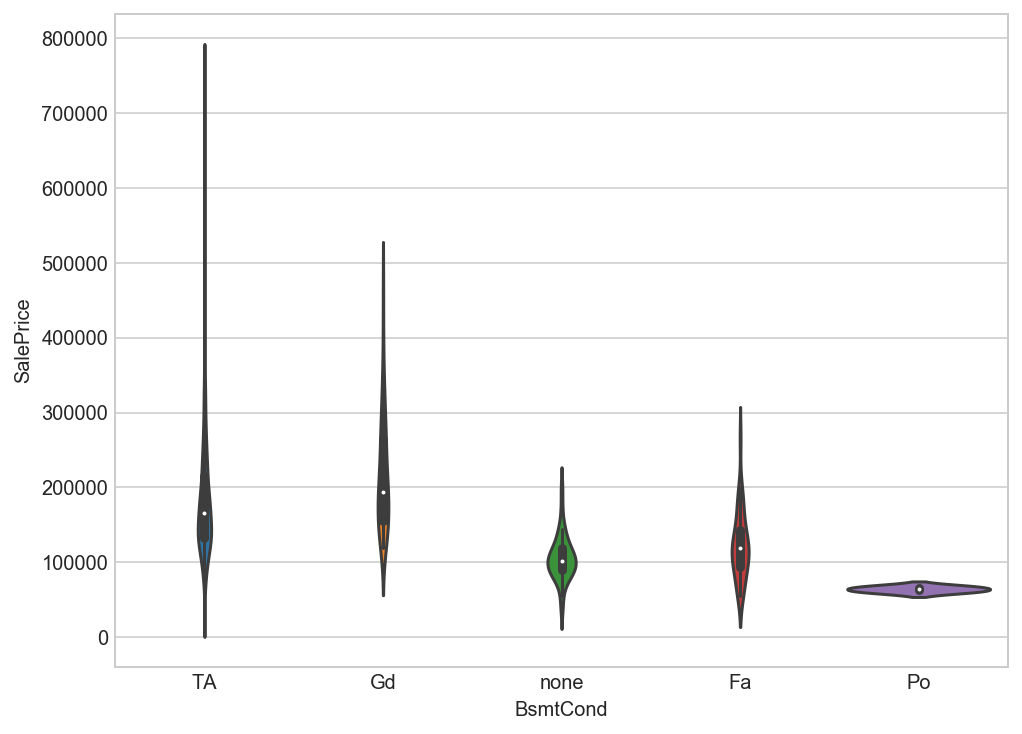

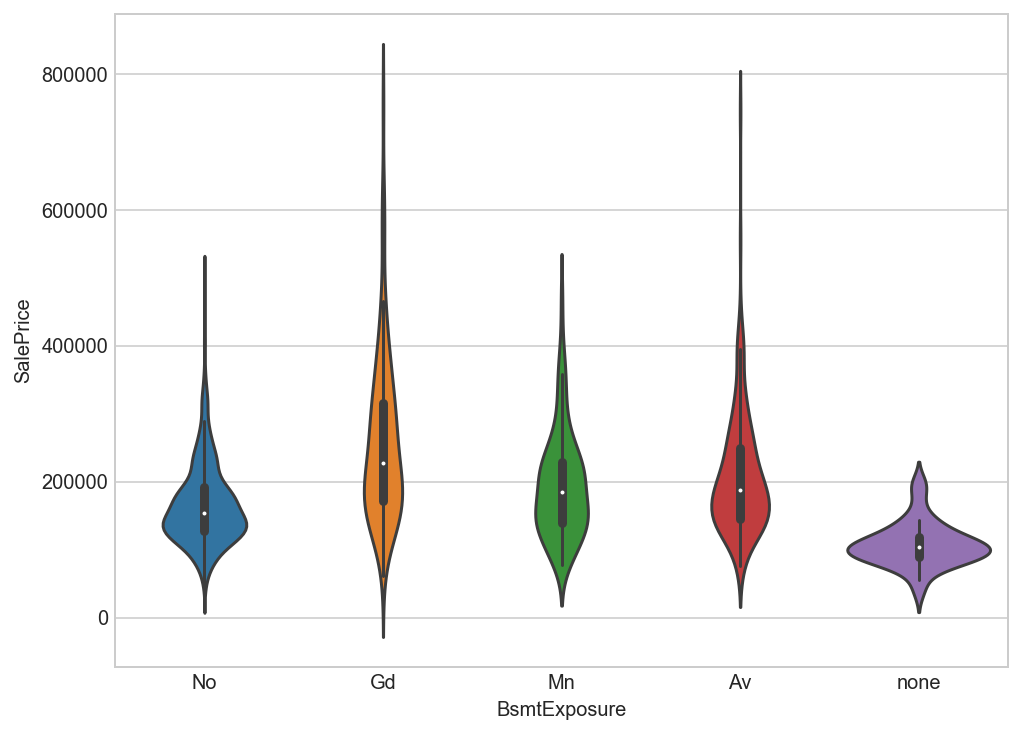

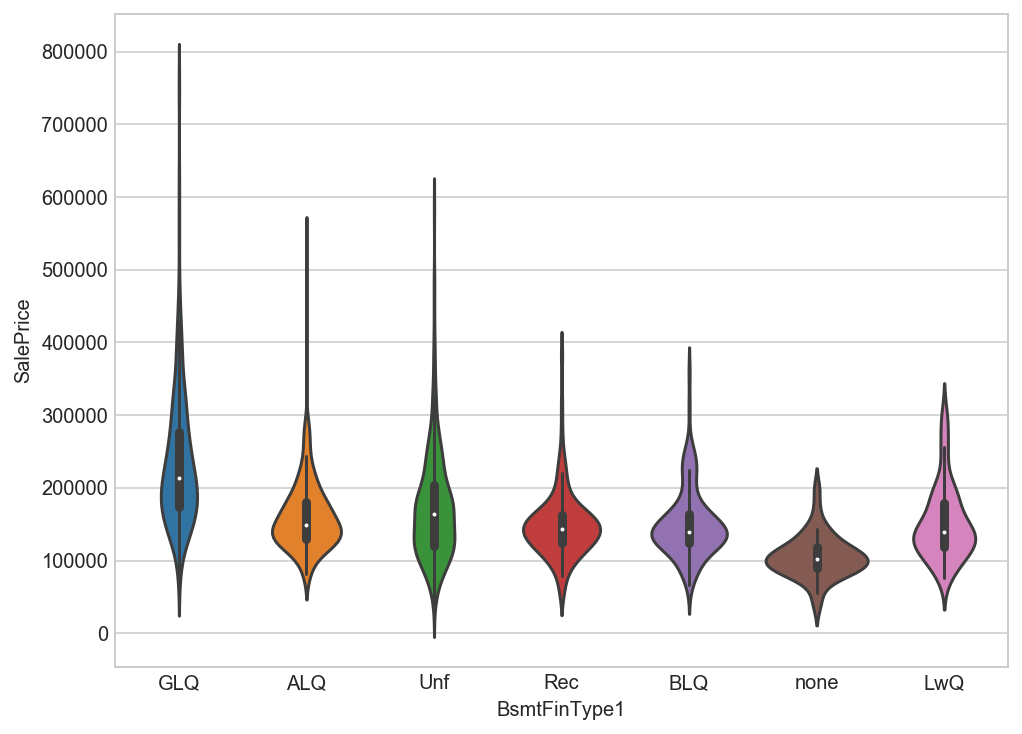

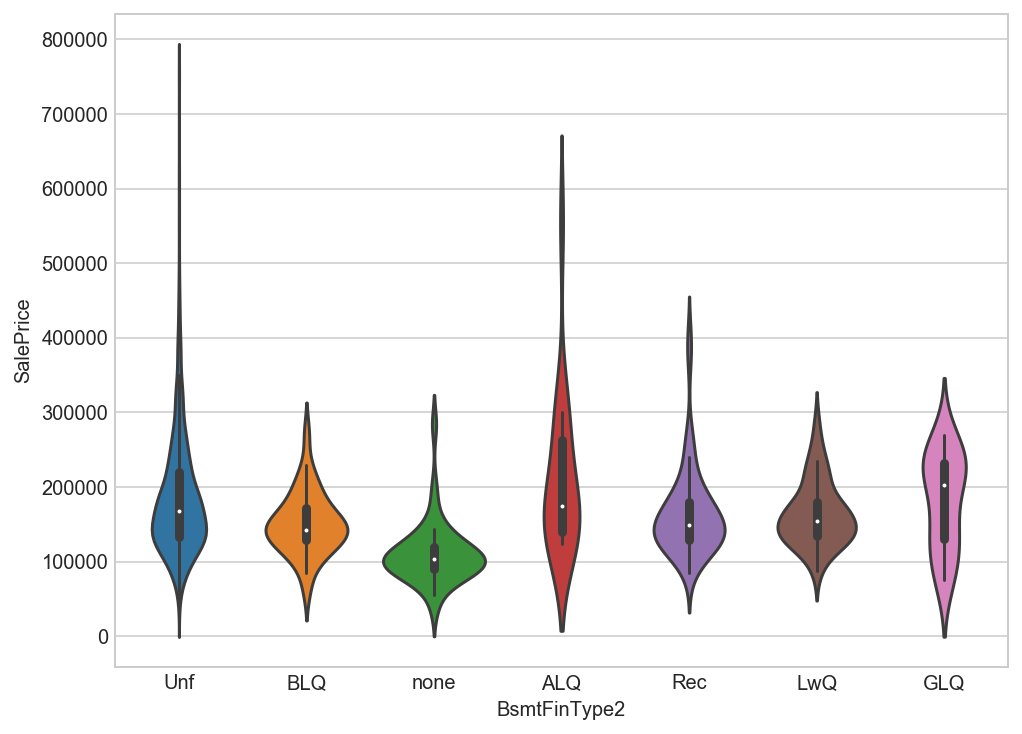

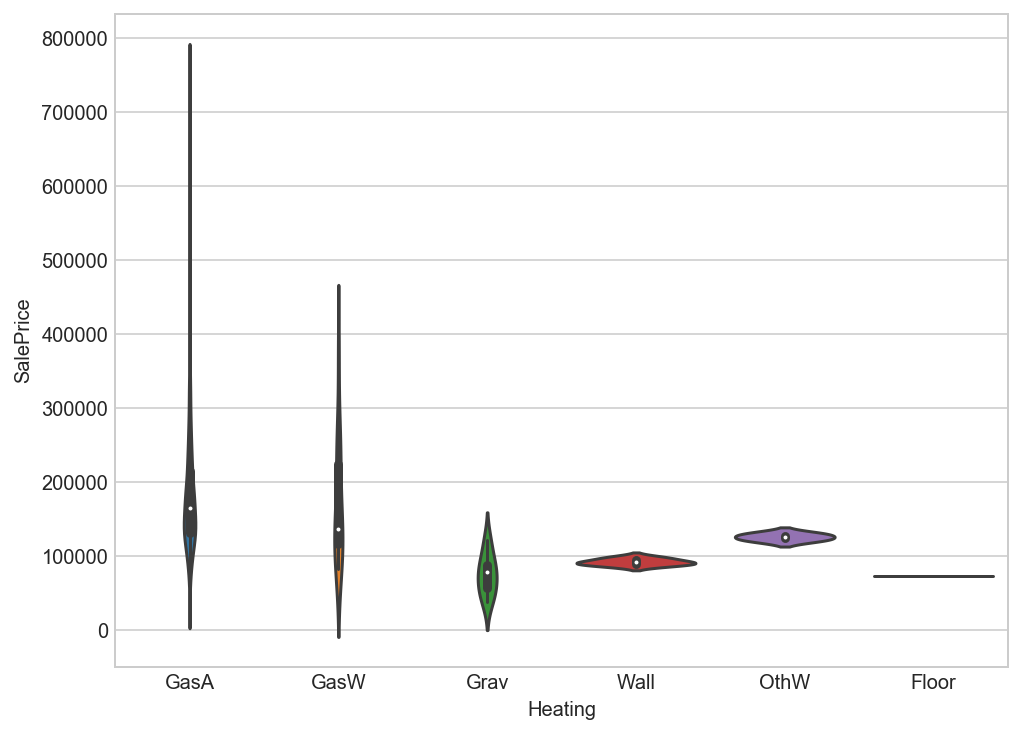

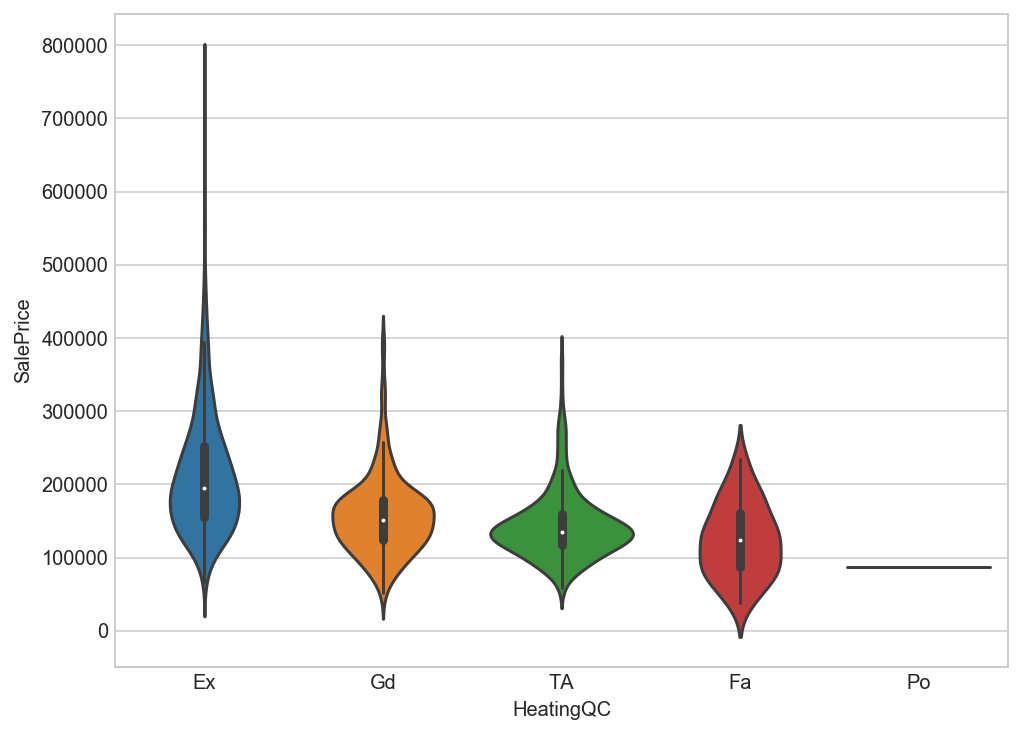

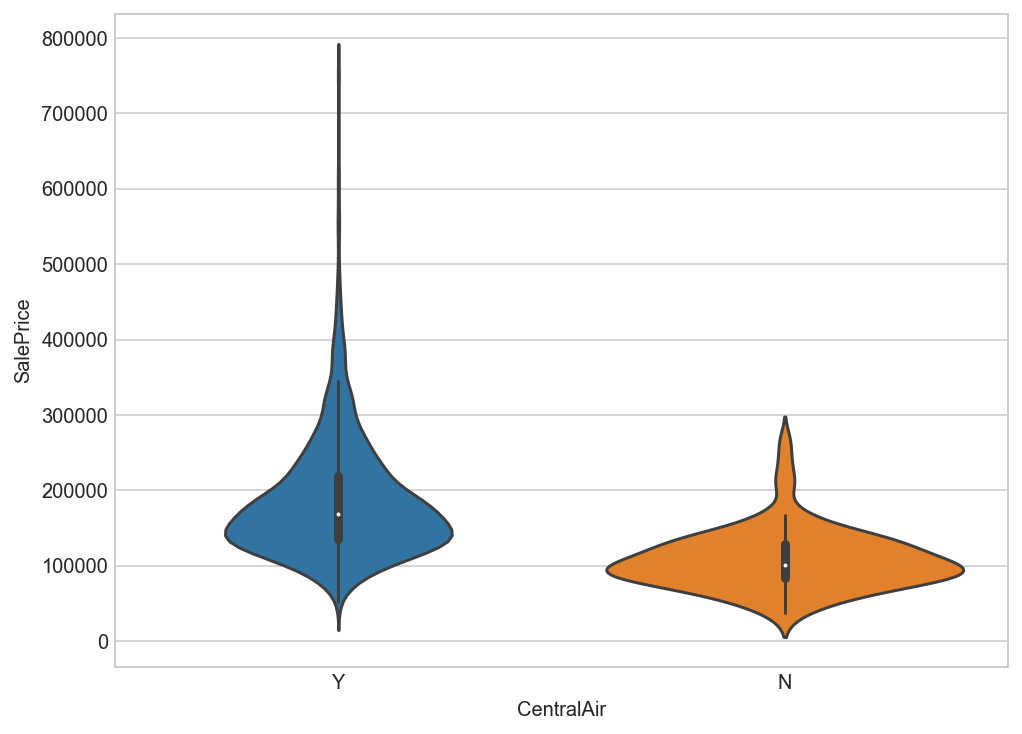

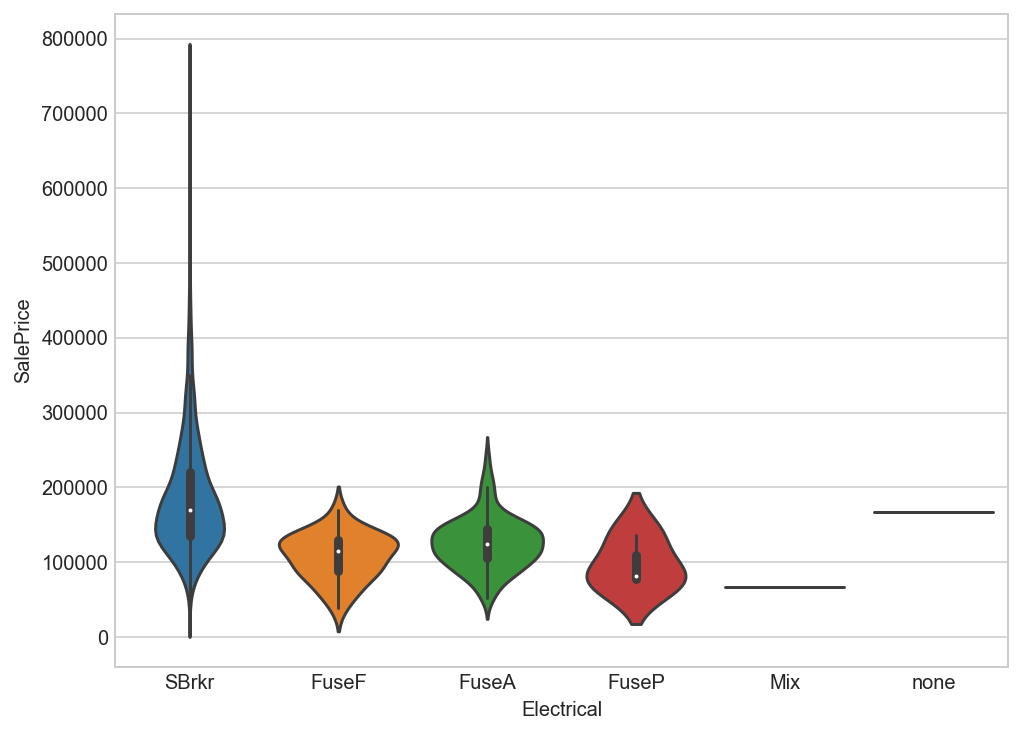

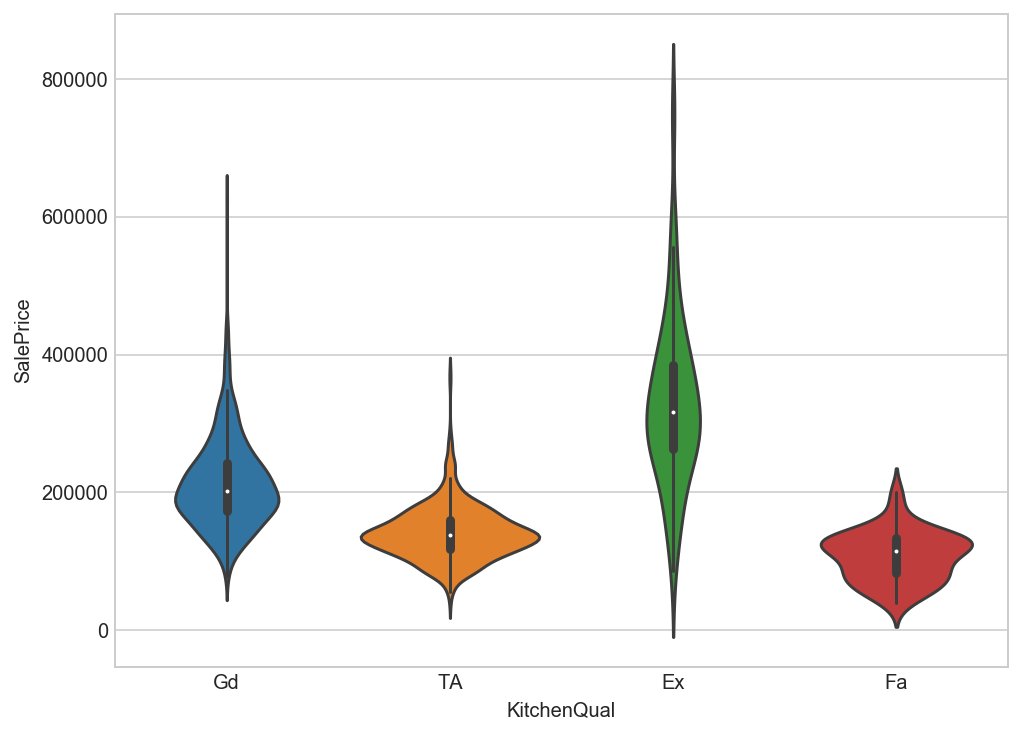

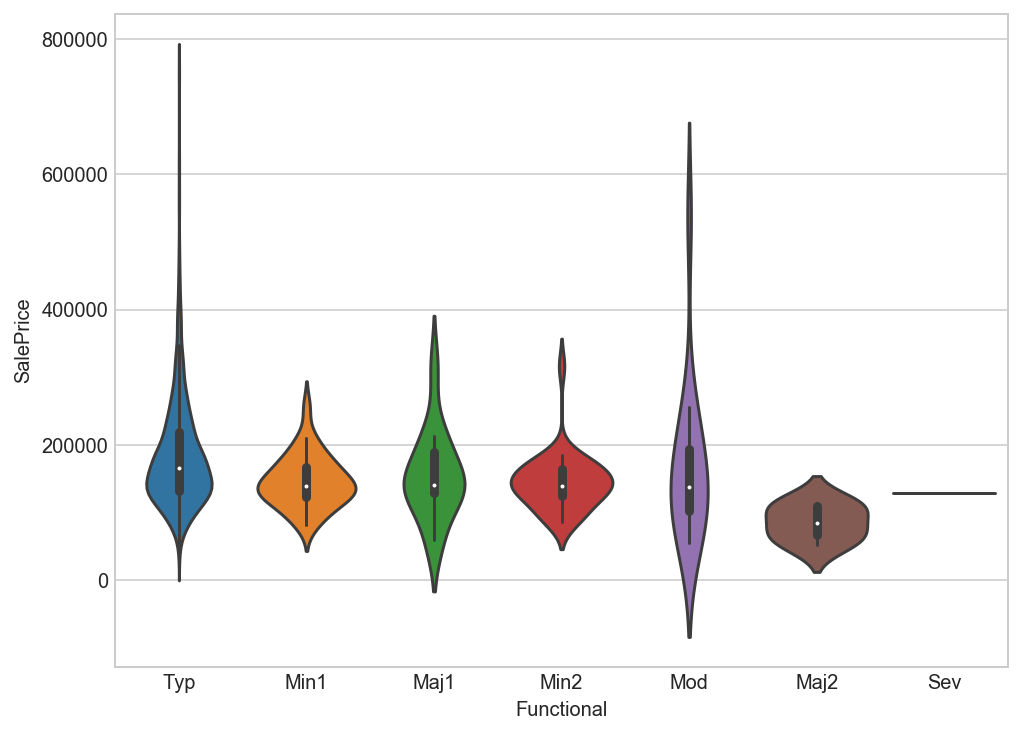

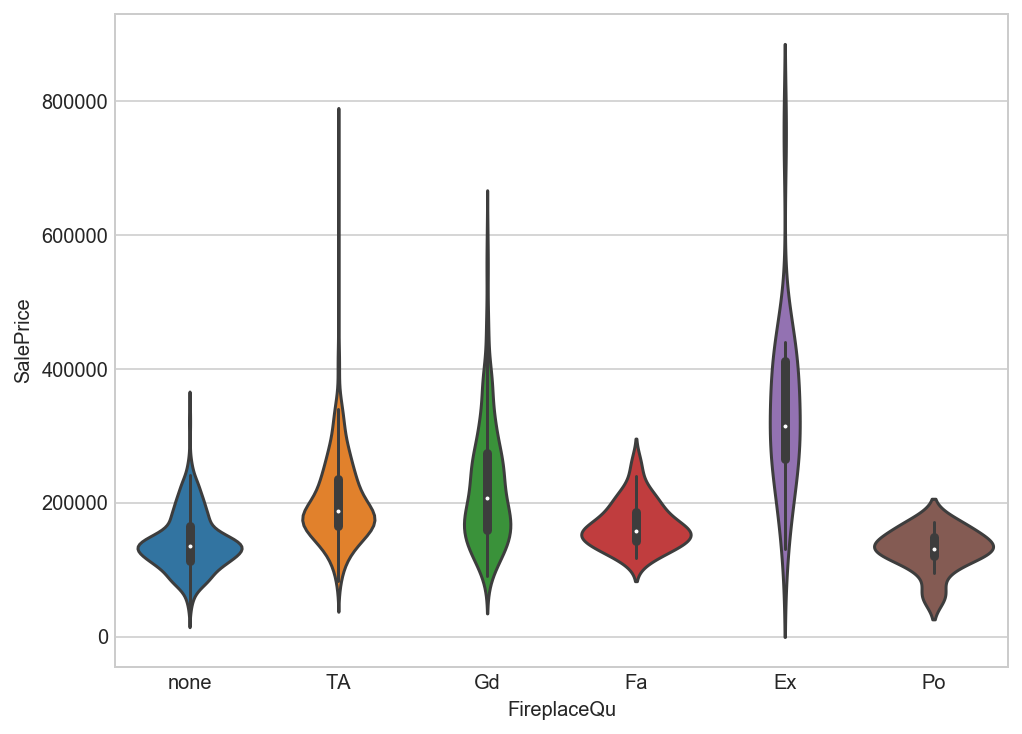

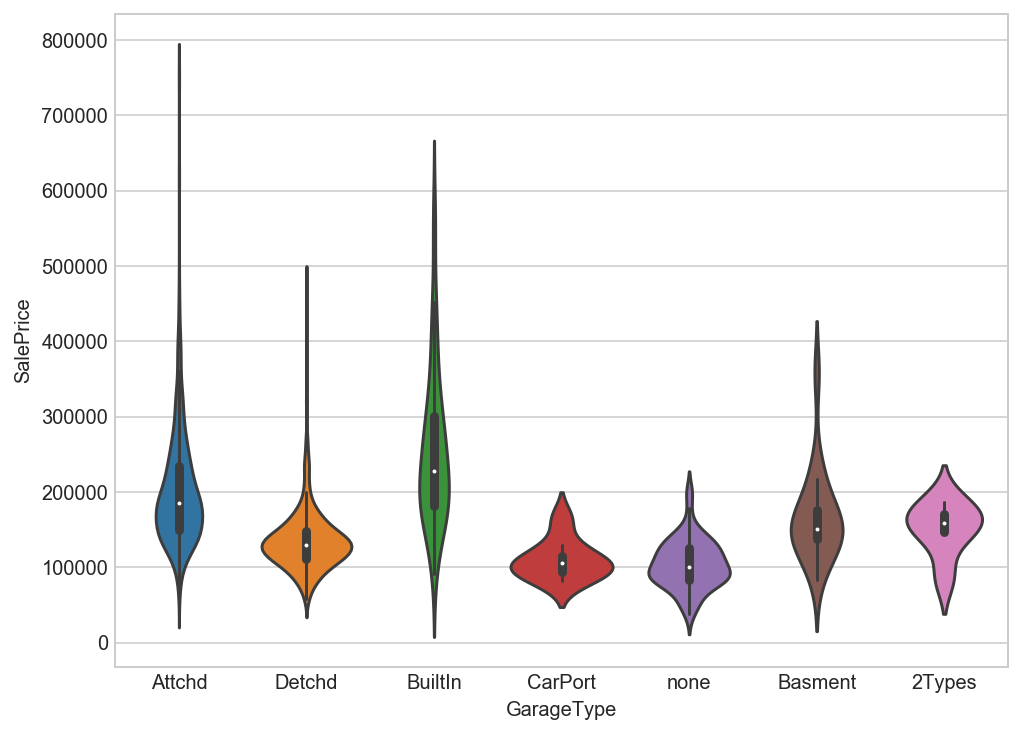

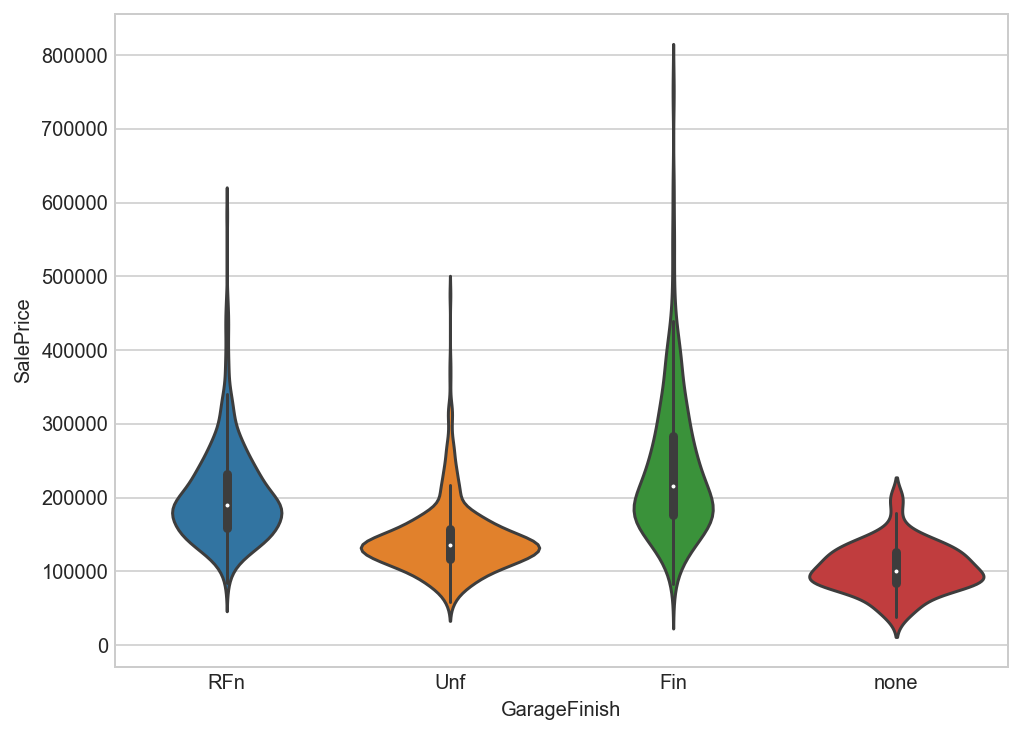

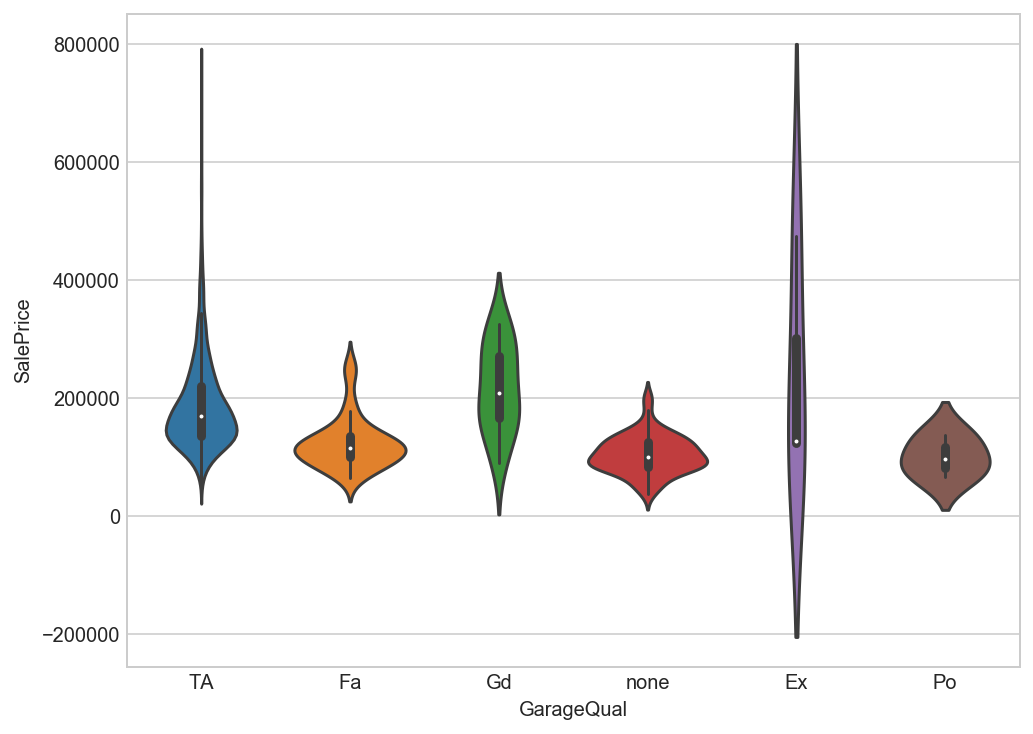

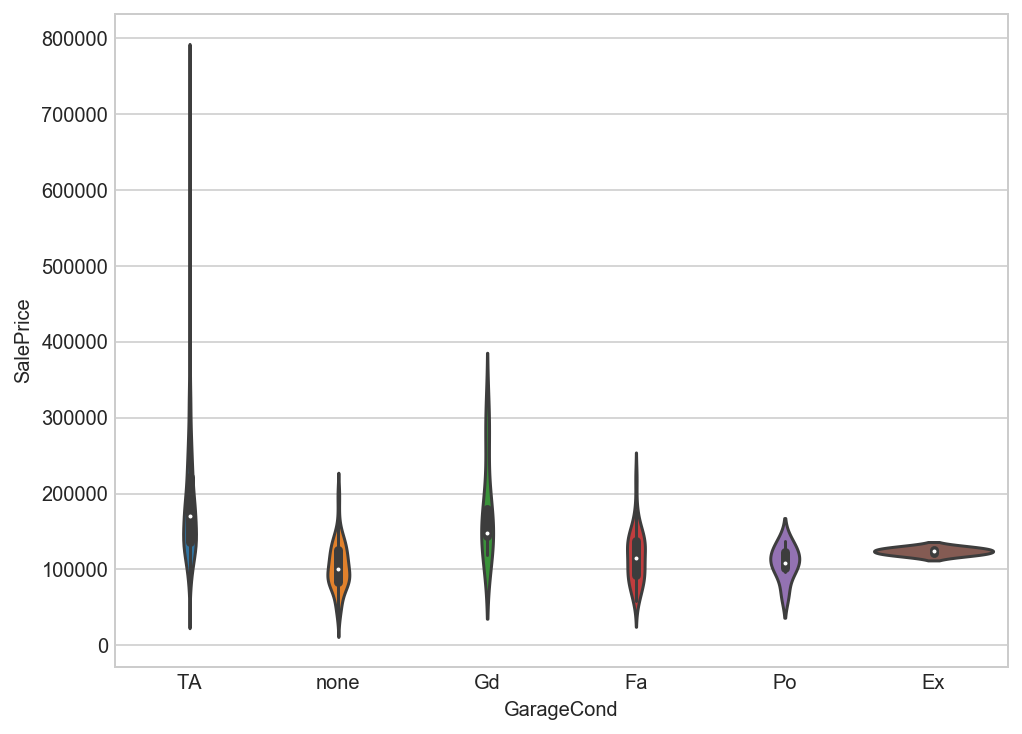

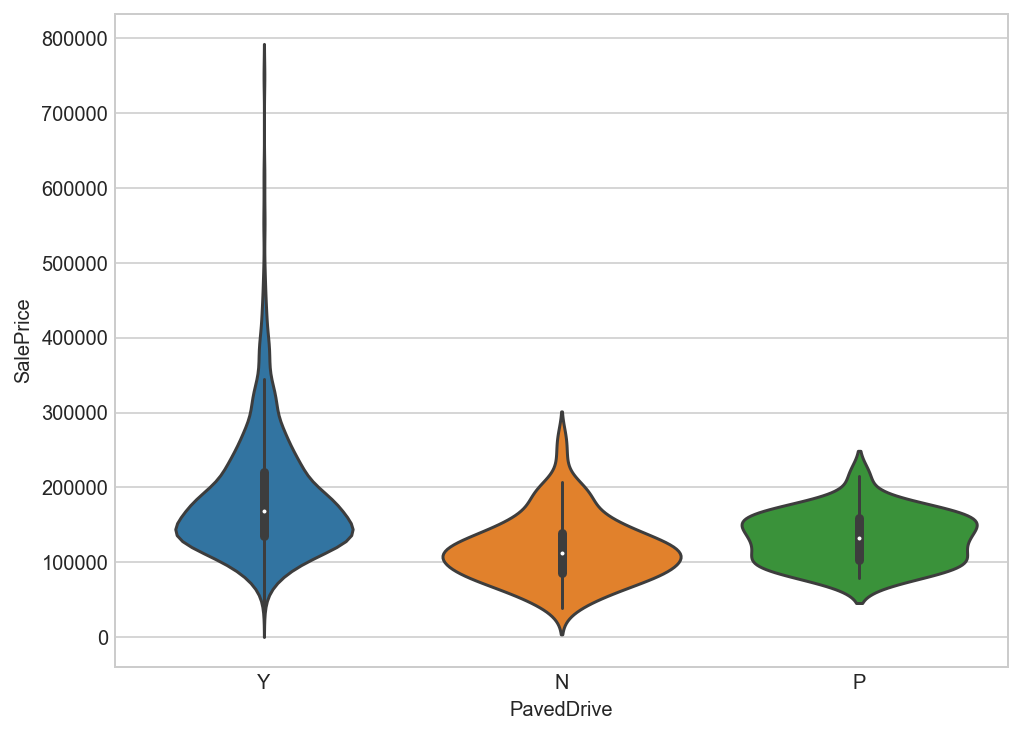

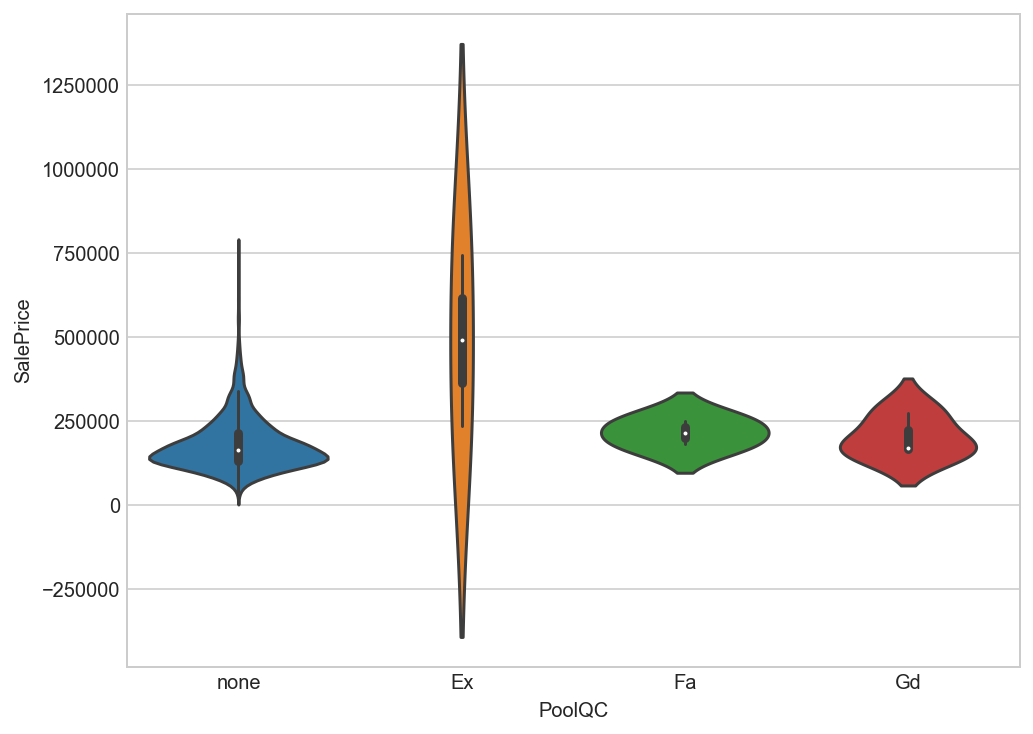

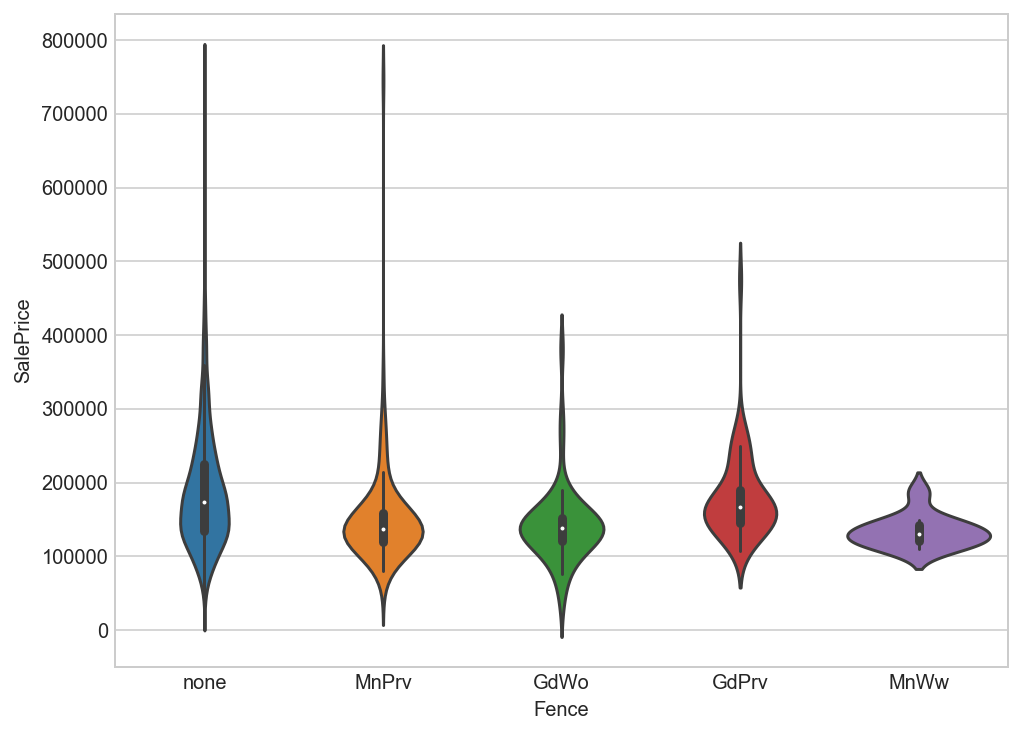

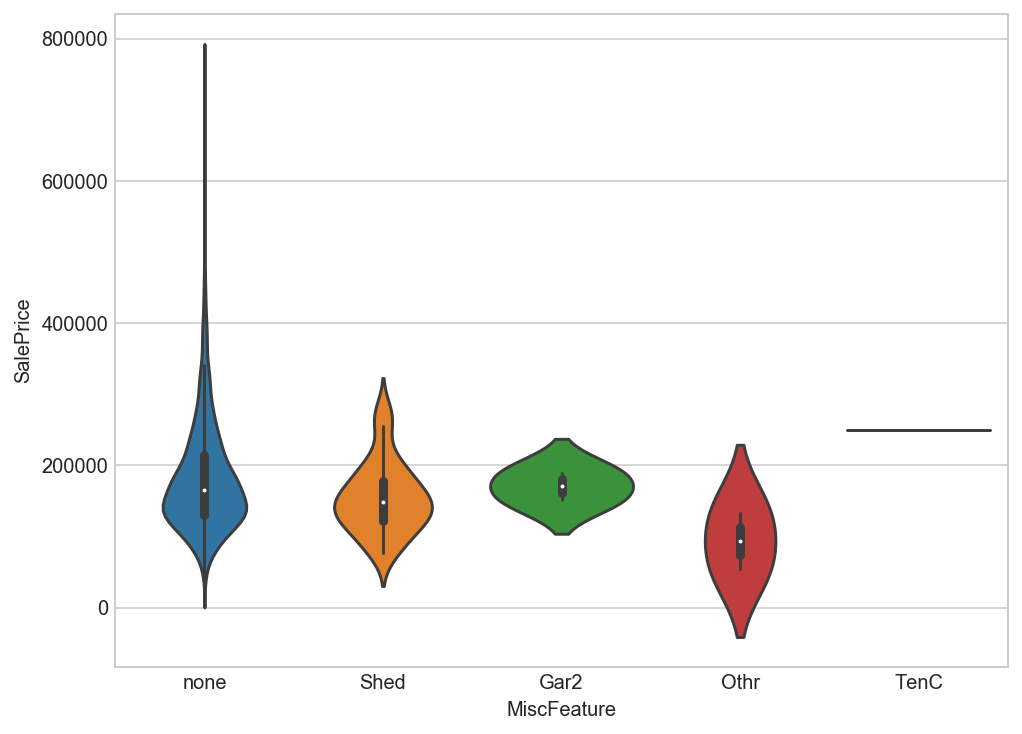

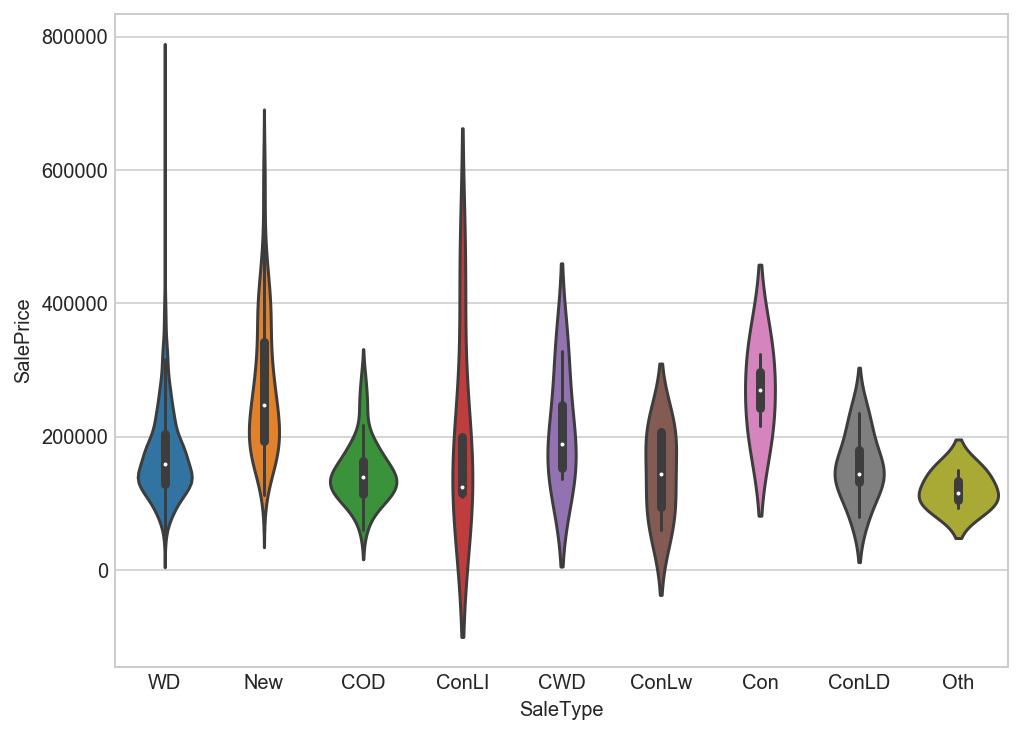

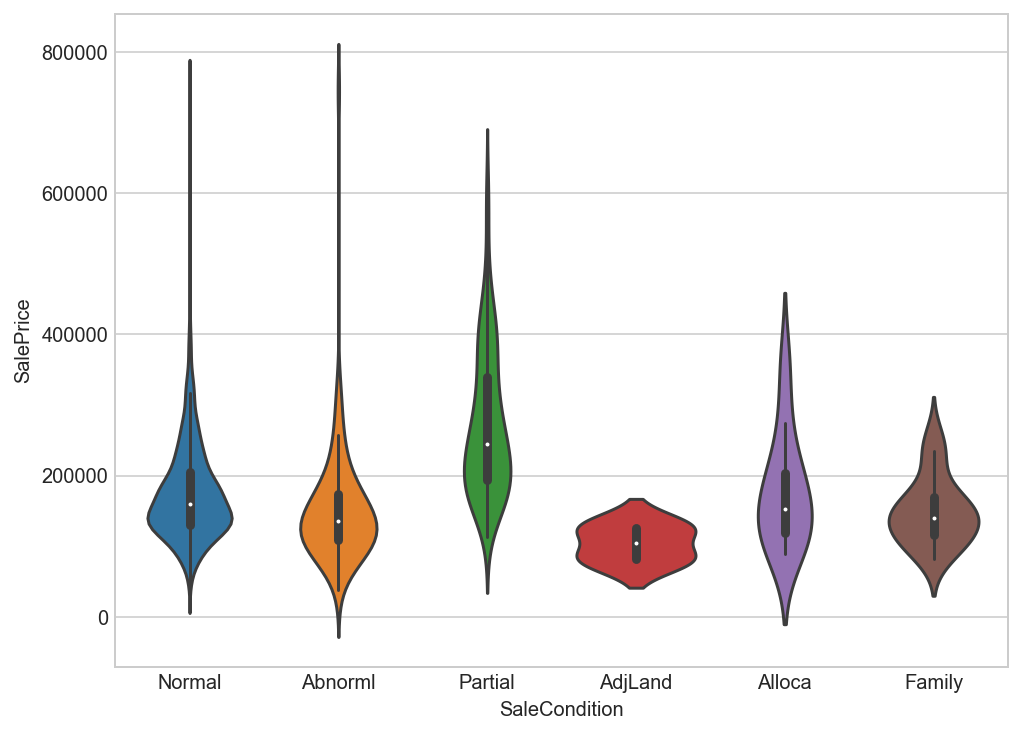

In [9]:
# plot violin plots for each categorical column ('objects')
for i in type_object.columns:
    plt.figure(figsize=(8,6))
    sns.violinplot(x=df[i], y=df['SalePrice'])

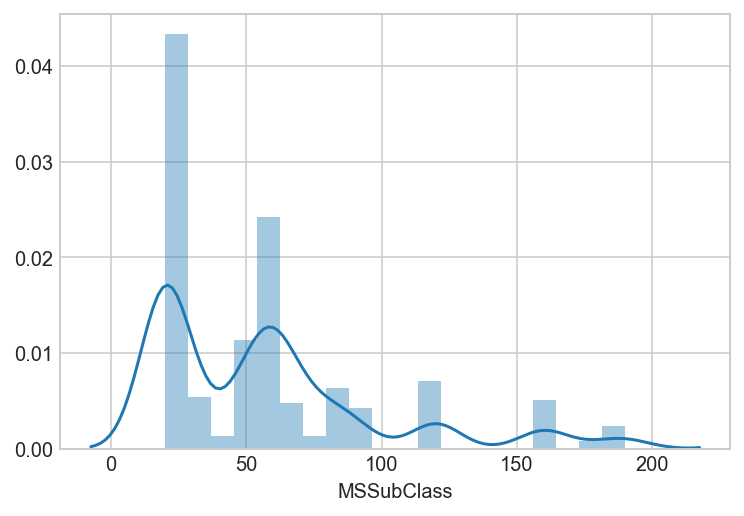

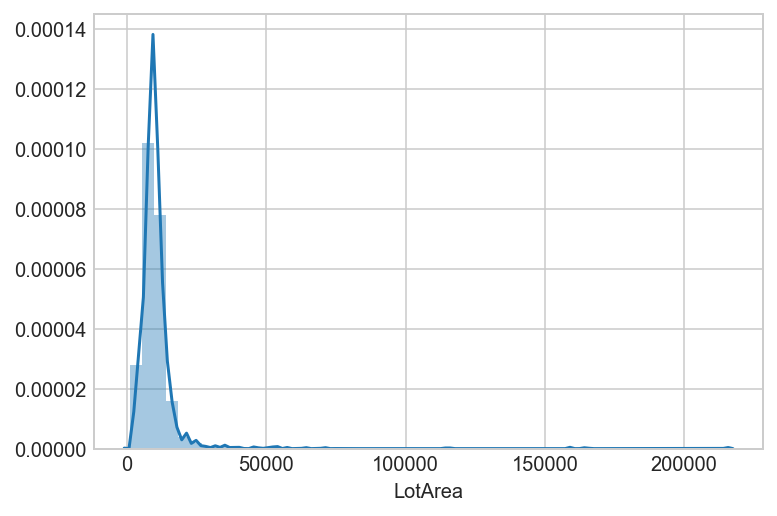

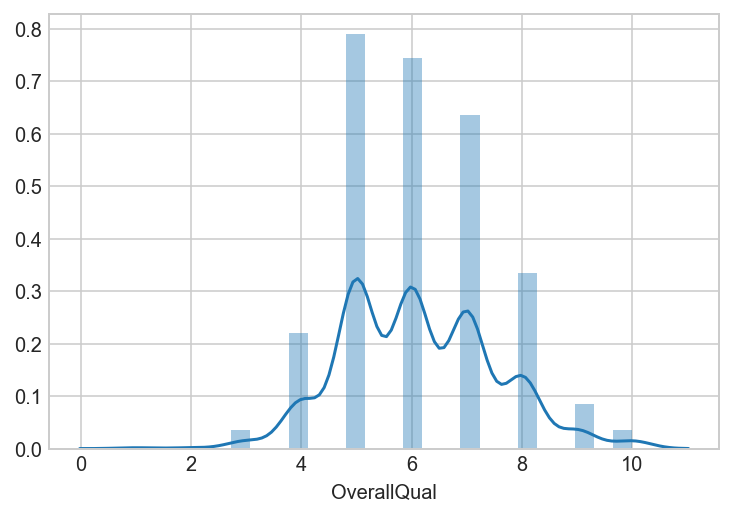

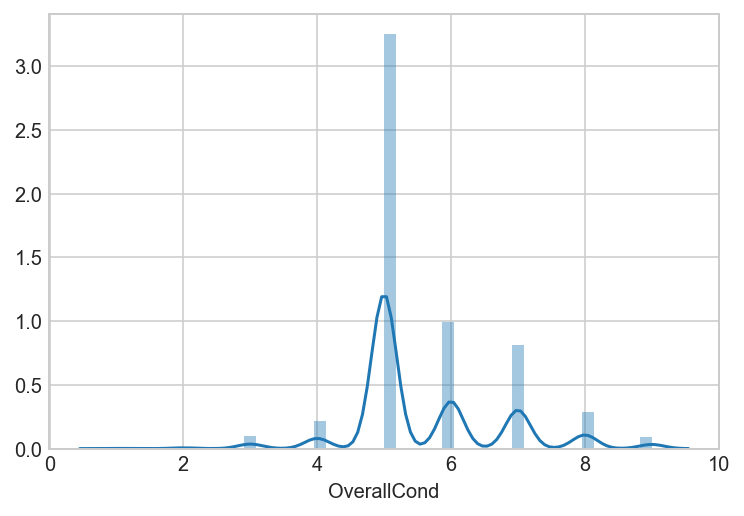

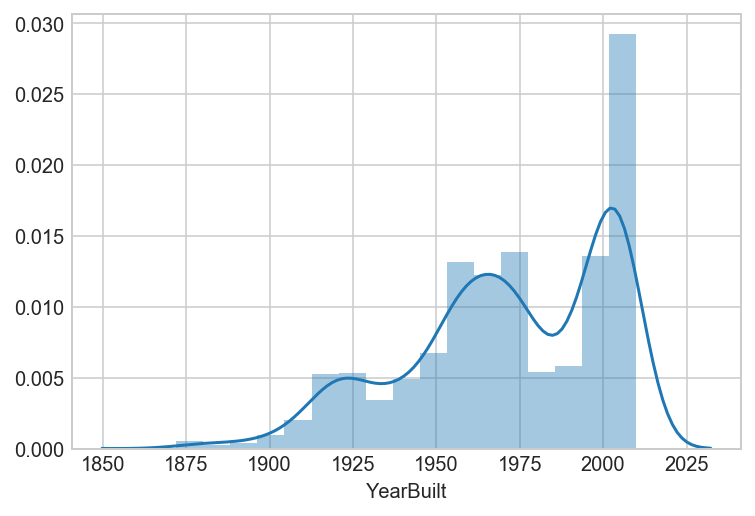

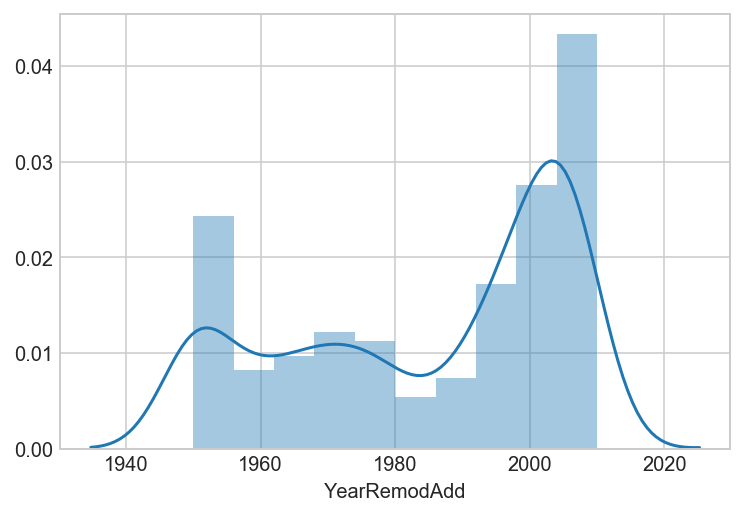

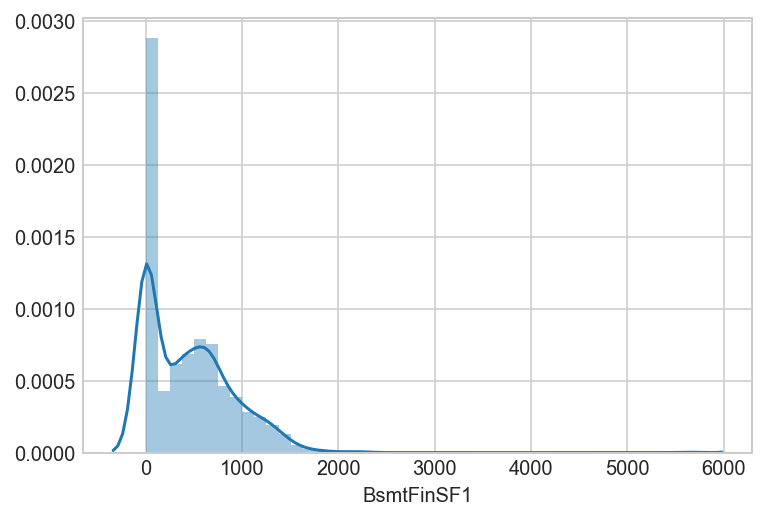

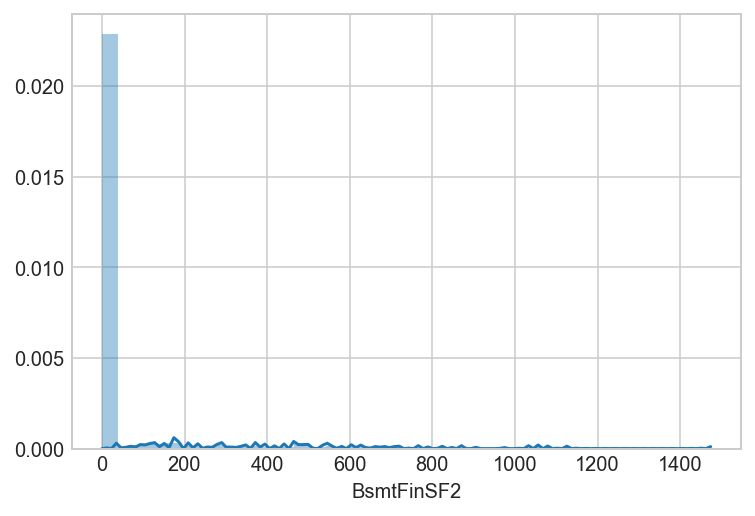

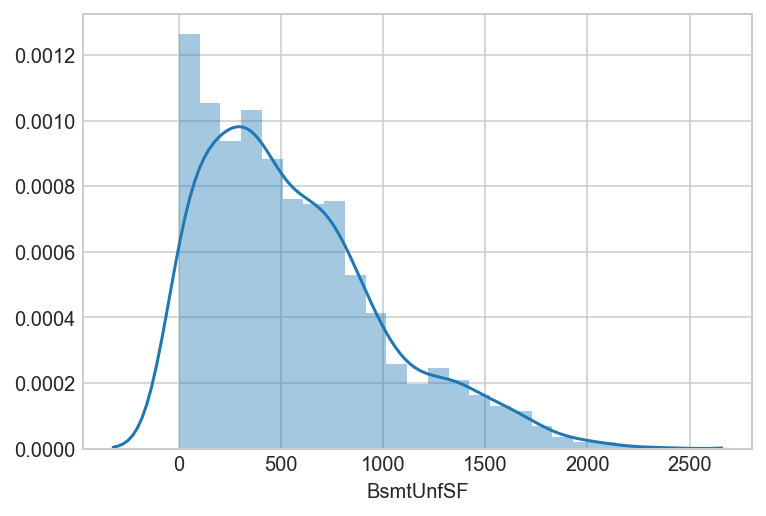

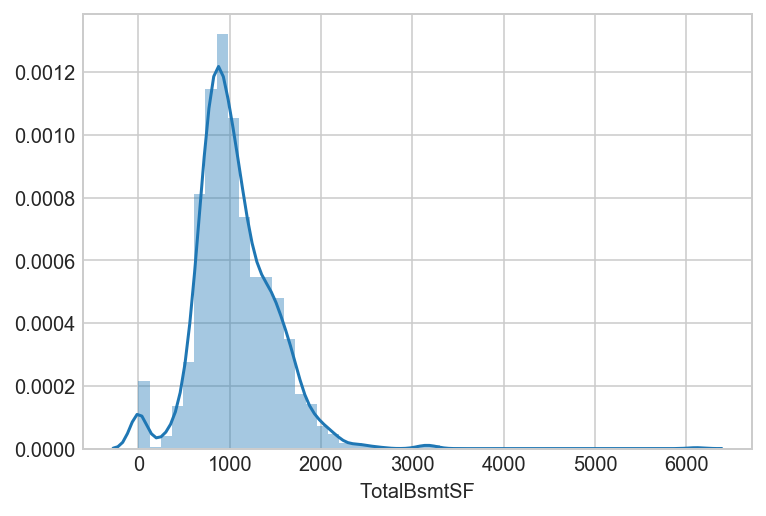

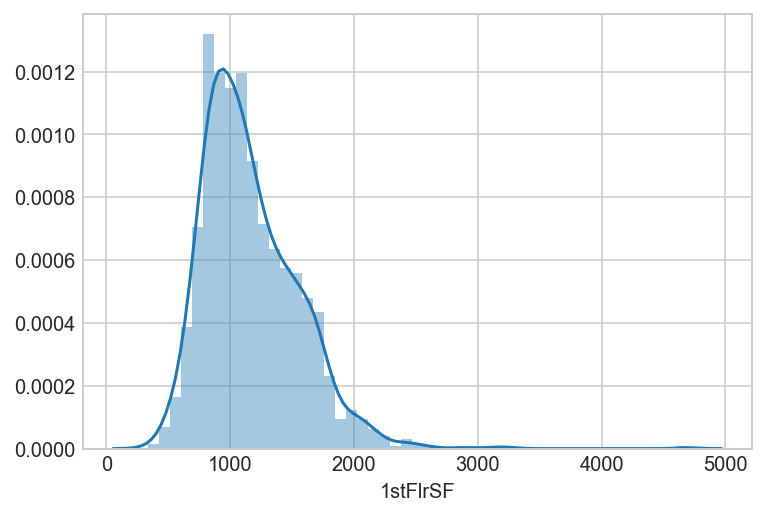

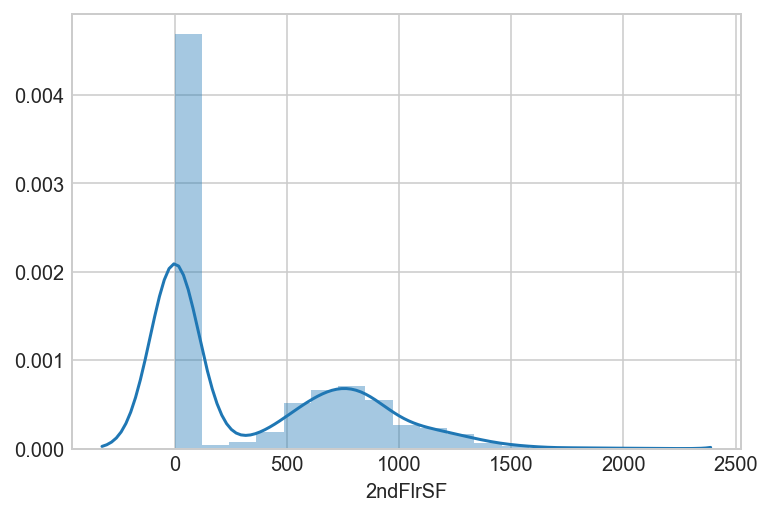

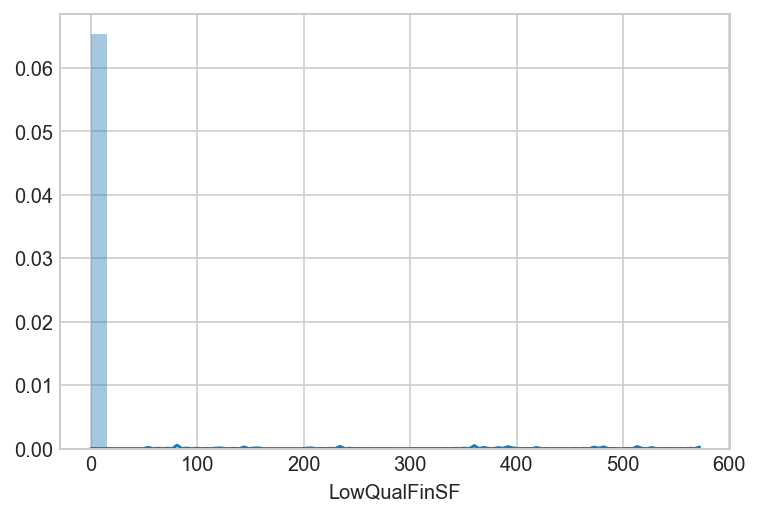

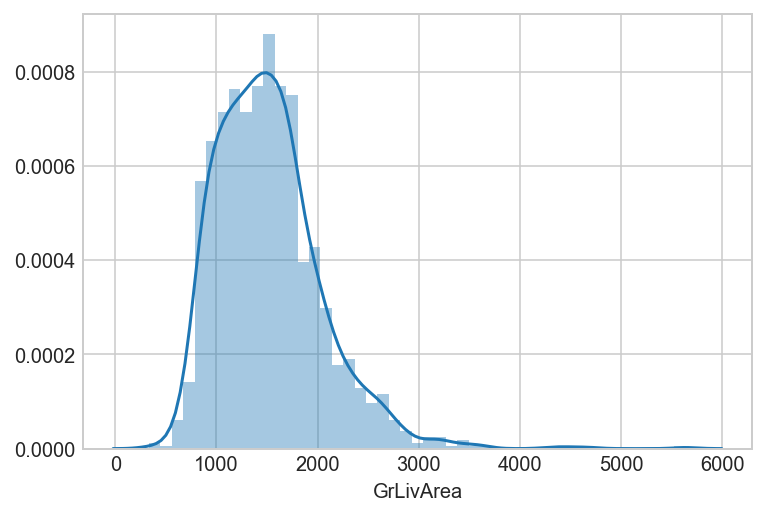

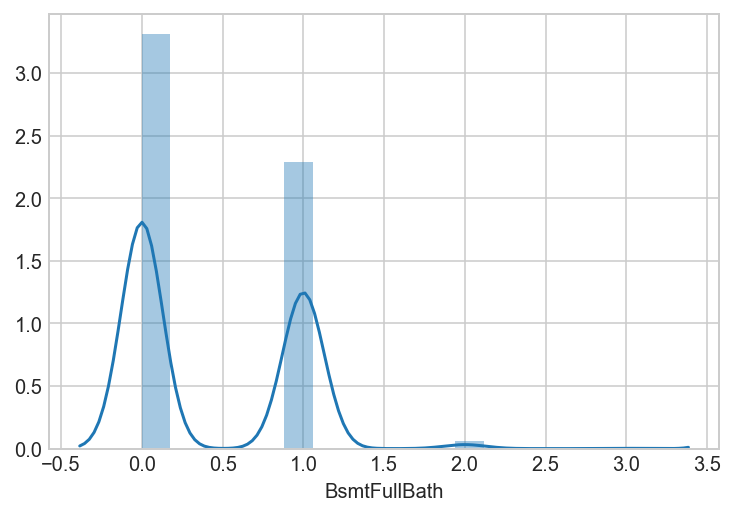

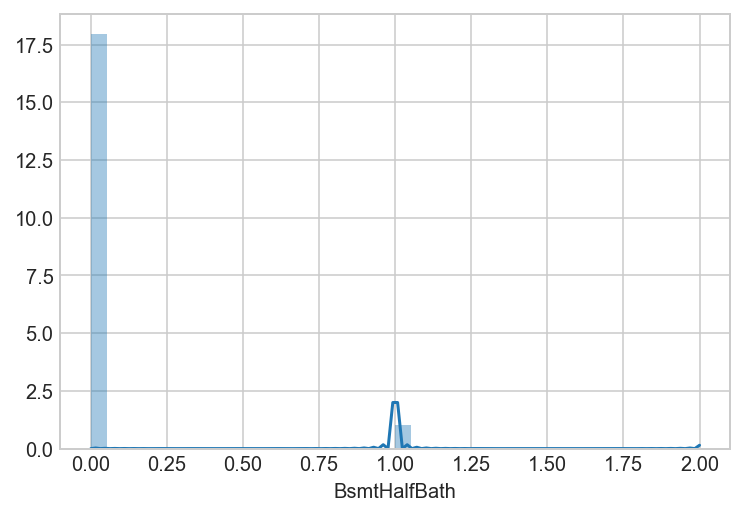

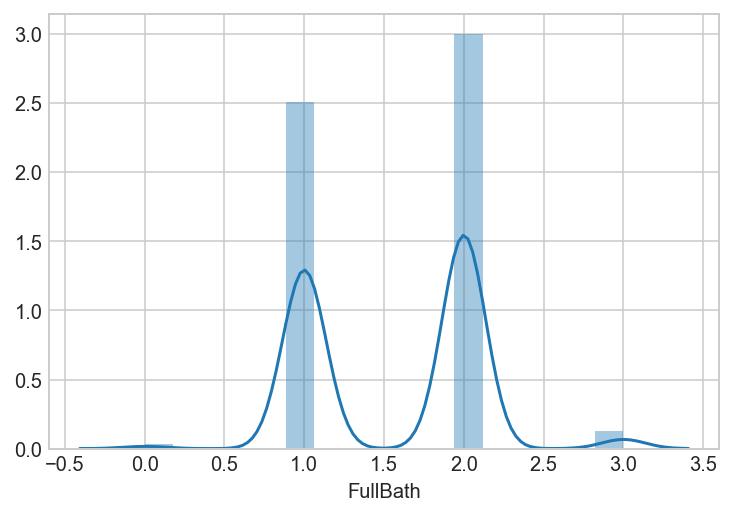

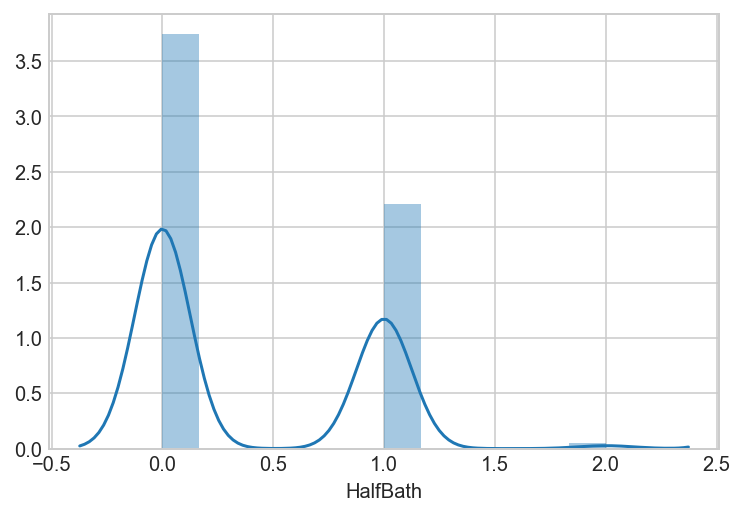

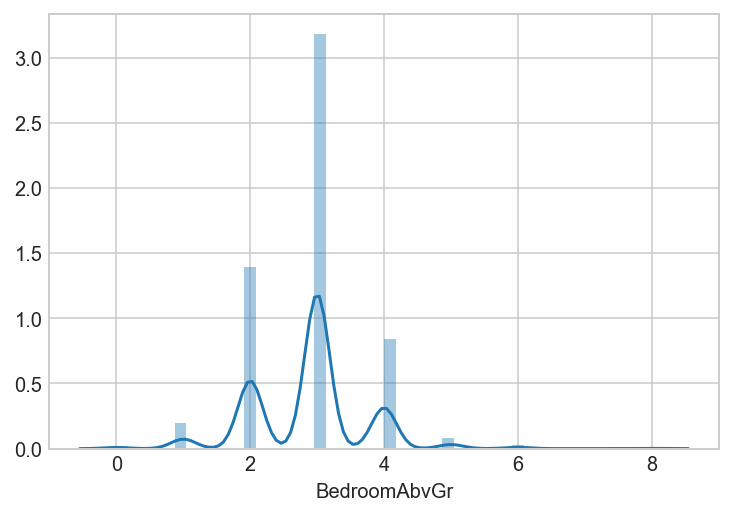

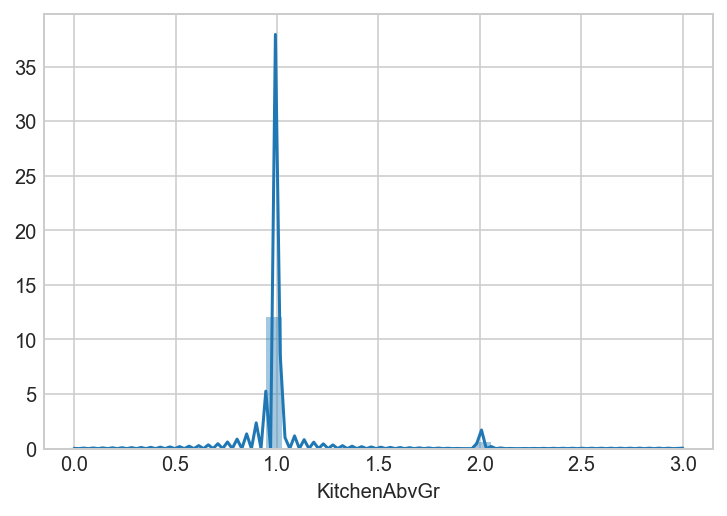

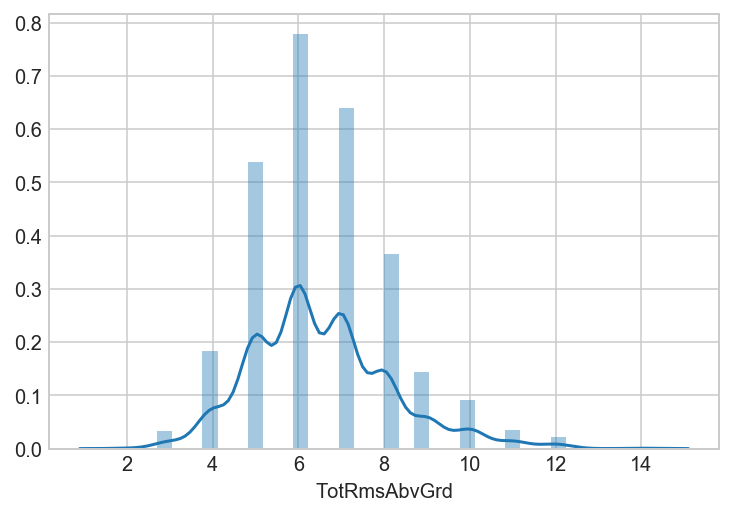

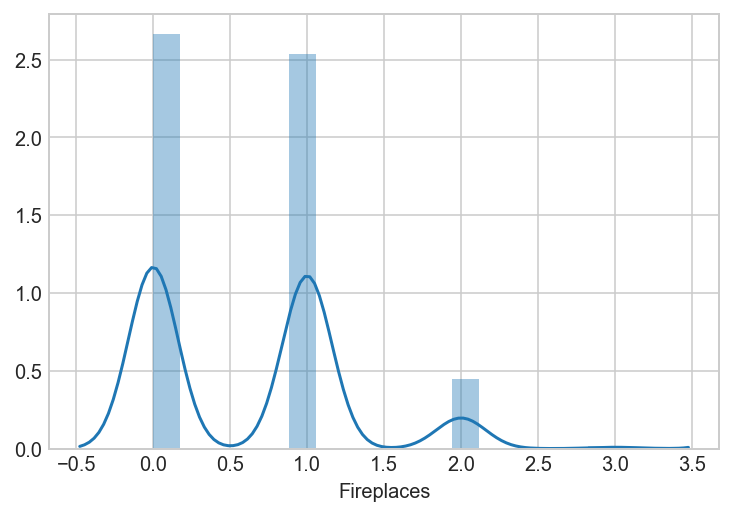

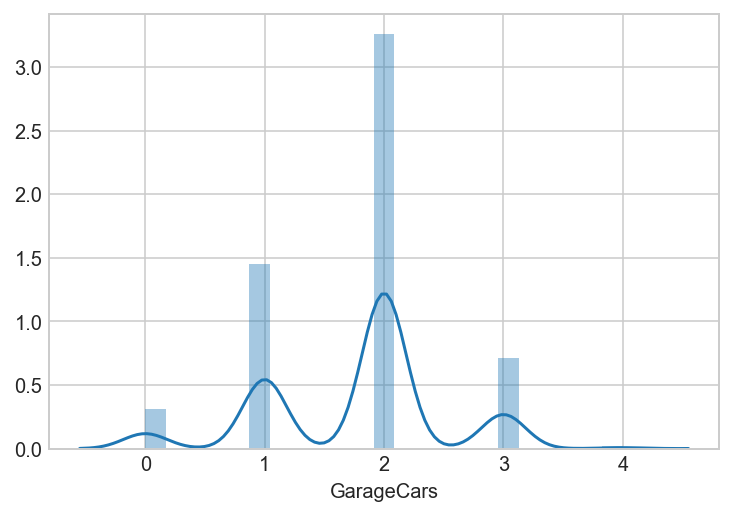

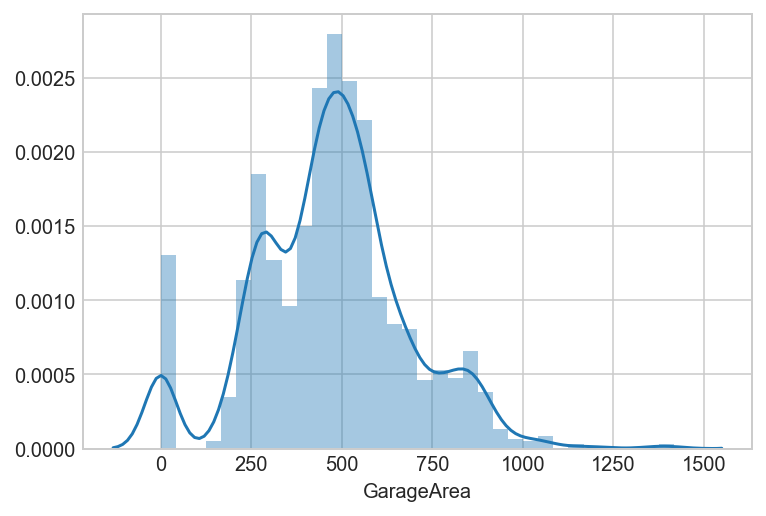

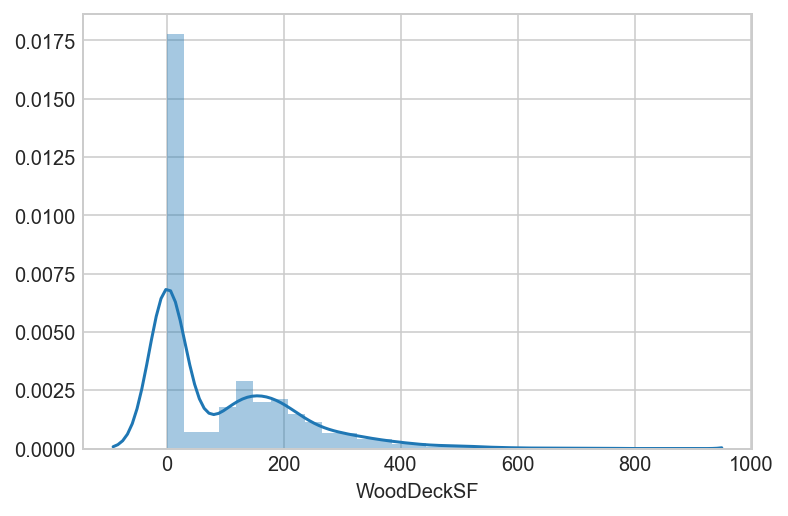

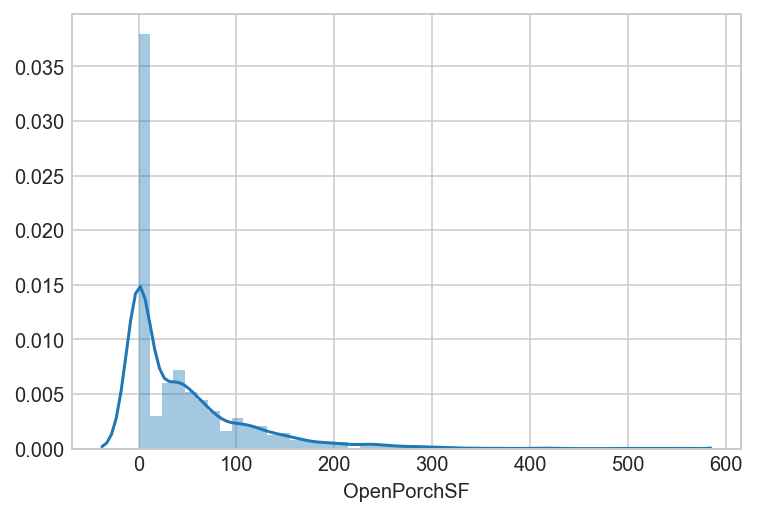

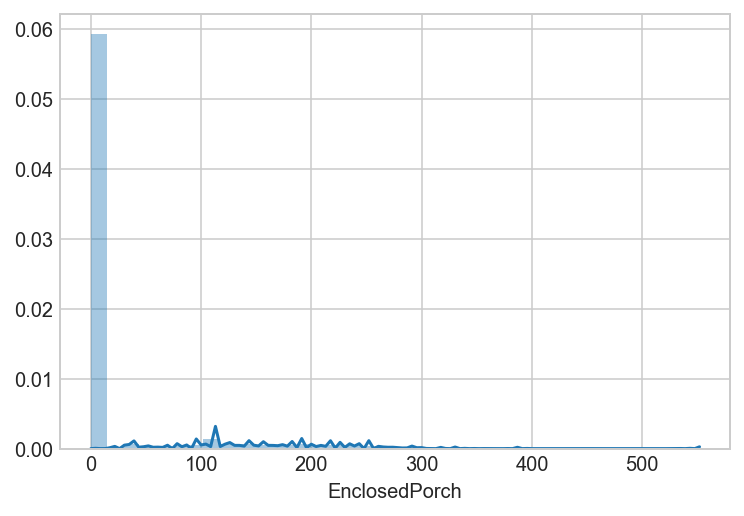

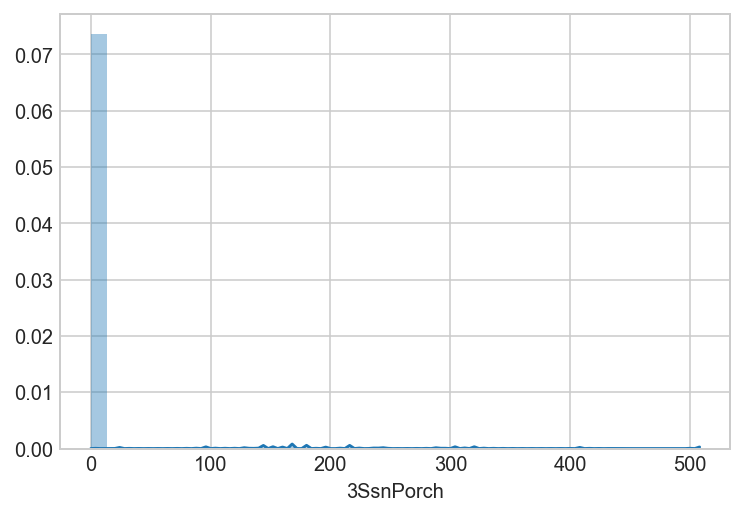

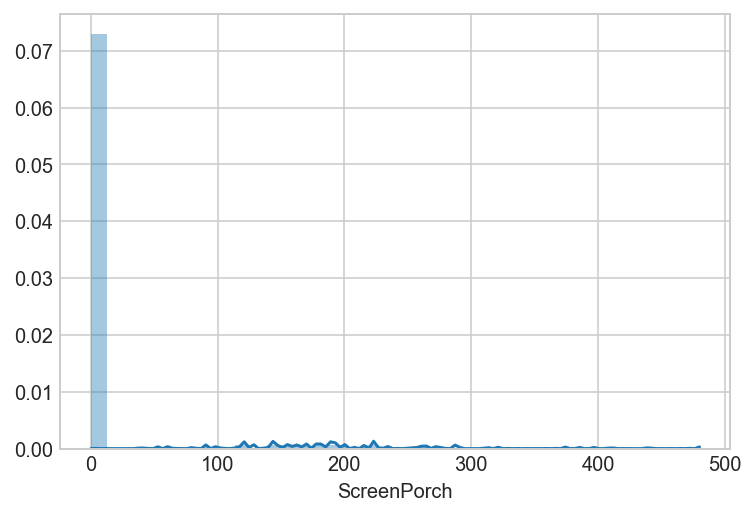

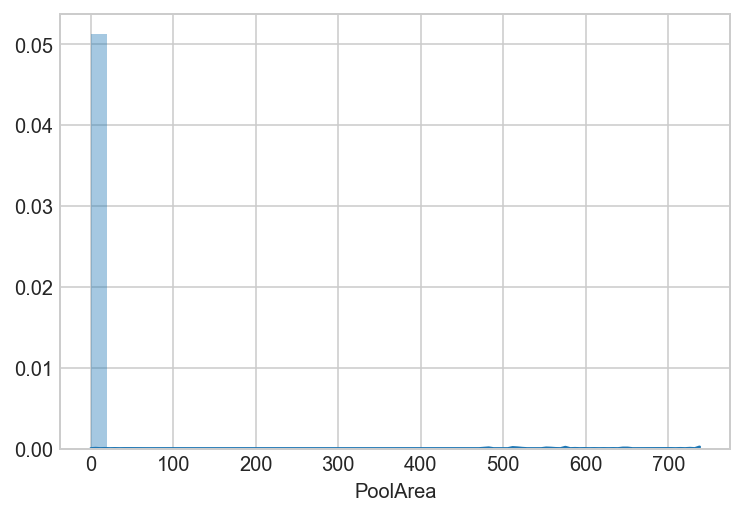

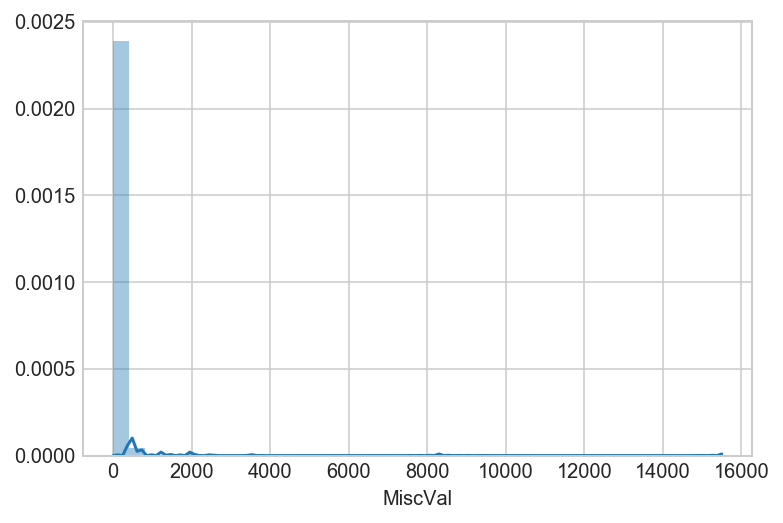

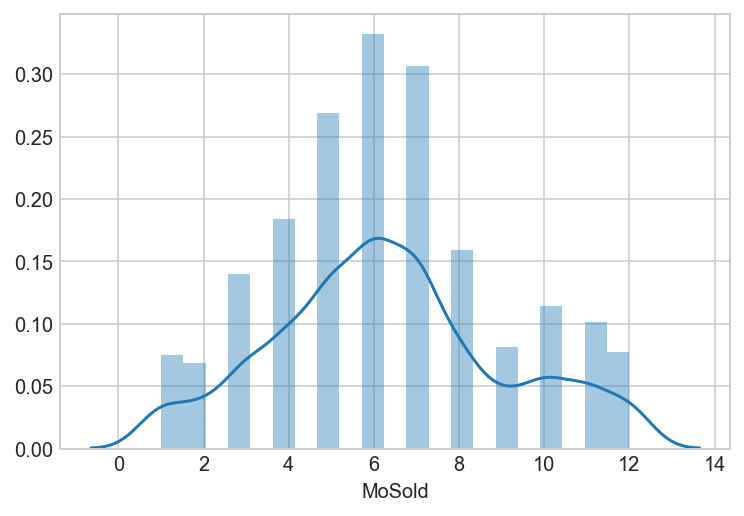

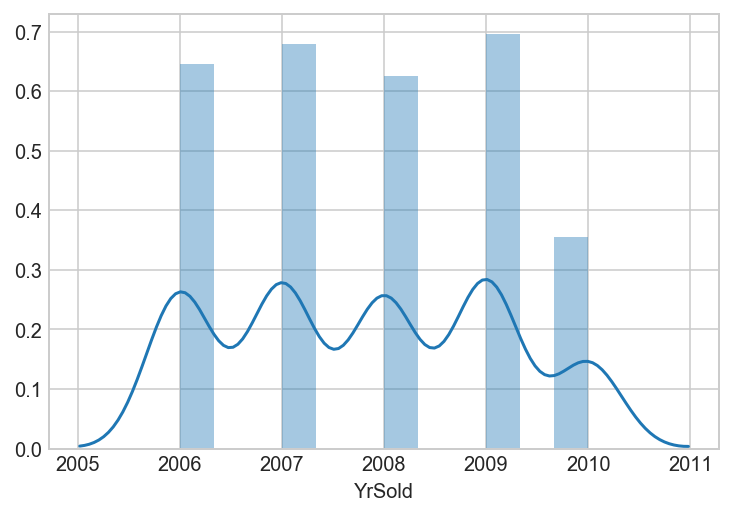

In [10]:
# plot distribution plots for each integer column
for i in type_integer.columns[1:-1]: # excl. Id & SalePrice
    plt.figure(figsize=(6,4))
    sns.distplot(df[i])

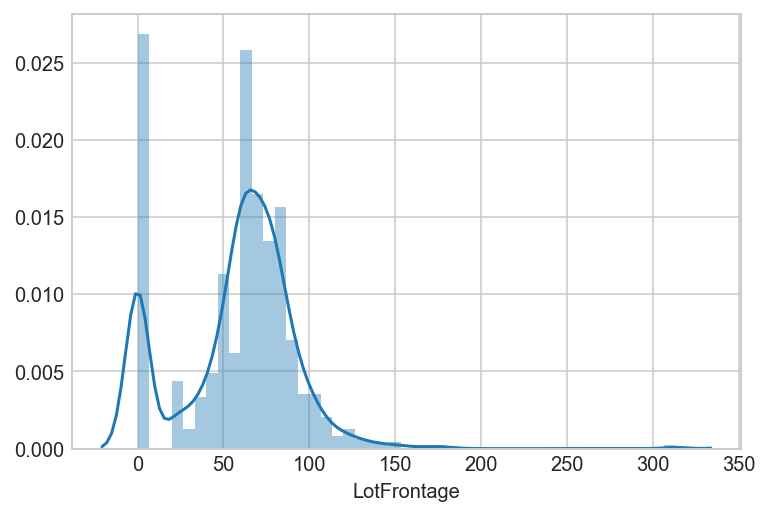

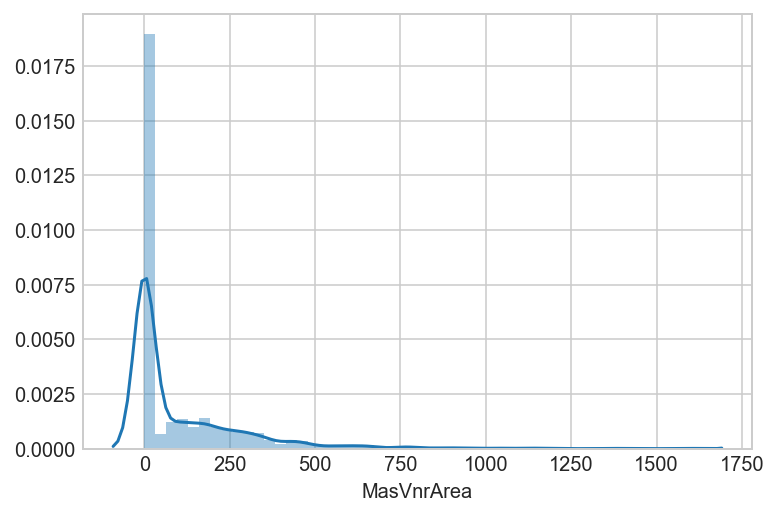

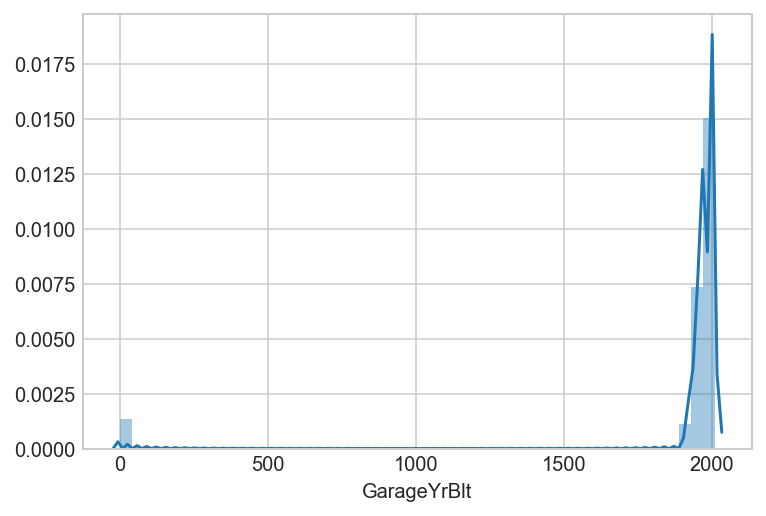

In [11]:
# plot distribution plots for each float column
for i in type_float.columns:
    plt.figure(figsize=(6,4))
    sns.distplot(df[i])

In [12]:
# Highly skewed columns on null values:
#  LowQualFinSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal

skewed_col = ['LowQualFinSF','EnclosedPorch','3SsnPorch','ScreenPorch',\
              'PoolArea', 'MiscVal']

for i in skewed_col:
    print('number of unique counts for {}: '.format(i), df[i].nunique())

number of unique counts for LowQualFinSF:  23
number of unique counts for EnclosedPorch:  118
number of unique counts for 3SsnPorch:  20
number of unique counts for ScreenPorch:  75
number of unique counts for PoolArea:  8
number of unique counts for MiscVal:  19


In [13]:
# integer columns with discrete distributions:
#  MSSubClass, OverallQual, OverallCond, BsmtFullBath, BsmtHalfBath,
#  FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd,
#  Fireplaces, GarageCars, MoSold, YrSold

distinct_col = ['MSSubClass','OverallQual','OverallCond','BsmtFullBath',\
                'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
                'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',\
                'MoSold','YrSold']

for i in distinct_col:
    print('value counts for {}: '.format(i), df[i].value_counts())

value counts for MSSubClass:  20     534
60     299
50     140
120     87
30      67
160     63
70      59
80      58
90      52
190     29
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
value counts for OverallQual:  5     396
6     373
7     319
8     168
4     111
9      43
10     18
3      18
2       2
1       2
Name: OverallQual, dtype: int64
value counts for OverallCond:  5    819
6    250
7    204
8     72
4     54
3     24
9     22
2      4
1      1
Name: OverallCond, dtype: int64
value counts for BsmtFullBath:  0    847
1    587
2     15
3      1
Name: BsmtFullBath, dtype: int64
value counts for BsmtHalfBath:  0    1369
1      79
2       2
Name: BsmtHalfBath, dtype: int64
value counts for FullBath:  2    767
1    642
3     33
0      8
Name: FullBath, dtype: int64
value counts for HalfBath:  0    904
1    534
2     12
Name: HalfBath, dtype: int64
value counts for BedroomAbvGr:  3    802
2    352
4    212
1     49
5     21
6      7
0      6

In [14]:
# convert integer columns with discrete distributions to categorical
# columns (integer -> string)

distinct_col = ['MSSubClass','OverallQual','OverallCond','BsmtFullBath',\
                'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
                'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',\
                'MoSold','YrSold']

for i in distinct_col:
    print('Old dtype for {}: '.format(i), df[i].dtype)
    df[i] = df[i].apply(str)
    print('New dtype for {}: '.format(i), df[i].dtype)

Old dtype for MSSubClass:  int64
New dtype for MSSubClass:  object
Old dtype for OverallQual:  int64
New dtype for OverallQual:  object
Old dtype for OverallCond:  int64
New dtype for OverallCond:  object
Old dtype for BsmtFullBath:  int64
New dtype for BsmtFullBath:  object
Old dtype for BsmtHalfBath:  int64
New dtype for BsmtHalfBath:  object
Old dtype for FullBath:  int64
New dtype for FullBath:  object
Old dtype for HalfBath:  int64
New dtype for HalfBath:  object
Old dtype for BedroomAbvGr:  int64
New dtype for BedroomAbvGr:  object
Old dtype for KitchenAbvGr:  int64
New dtype for KitchenAbvGr:  object
Old dtype for TotRmsAbvGrd:  int64
New dtype for TotRmsAbvGrd:  object
Old dtype for Fireplaces:  int64
New dtype for Fireplaces:  object
Old dtype for GarageCars:  int64
New dtype for GarageCars:  object
Old dtype for MoSold:  int64
New dtype for MoSold:  object
Old dtype for YrSold:  int64
New dtype for YrSold:  object


---
### Creating dummy variables

**1c**. Identify **fixed** features that can predict price.

In [15]:
df.corr()['SalePrice']

Id              -0.024353
LotFrontage      0.214273
LotArea          0.264715
YearBuilt        0.517602
YearRemodAdd     0.501186
MasVnrArea       0.471056
BsmtFinSF1       0.384475
BsmtFinSF2      -0.014145
BsmtUnfSF        0.216152
TotalBsmtSF      0.612088
1stFlrSF         0.603300
2ndFlrSF         0.319774
LowQualFinSF    -0.018755
GrLivArea        0.708658
GarageYrBlt      0.258923
GarageArea       0.629831
WoodDeckSF       0.320770
OpenPorchSF      0.329491
EnclosedPorch   -0.120765
3SsnPorch        0.043807
ScreenPorch      0.110540
PoolArea         0.092396
MiscVal         -0.021052
SalePrice        1.000000
Name: SalePrice, dtype: float64

In [16]:
# create dummy variables for fixed categorical columns (27) & combine
# with fixed integer/float columns (4) & fixed sqft columns (13)
# columns with very low correlation (+ve/-ve <0.1) not included

fixed_dummy_var = ['MSZoning','Street','Alley','LotShape',\
                   'LandContour','Utilities','LotConfig','LandSlope',\
                   'Neighborhood','Condition1','Condition2','BldgType',\
                   'HouseStyle','PavedDrive','MiscFeature',\
                   'YrSold','Foundation','BsmtQual','BsmtExposure',\
                   'BsmtFullBath','FullBath','HalfBath',\
                   'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',\
                   'Functional','GarageType']

fixed_int = df[['YearBuilt','YearRemodAdd',\
                'GarageYrBlt','GarageCars']].copy()

df_sqft = df[['LotFrontage','LotArea','BsmtFinSF1',\
              'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
              'GrLivArea','GarageArea','WoodDeckSF',\
              'OpenPorchSF','EnclosedPorch','ScreenPorch']].copy()

df_fixed = pd.concat([fixed_int,df_sqft],axis=1)

for i in fixed_dummy_var:
    print('Categories in {}: '.format(i), df[i].unique())
    dummies = pd.get_dummies(df[i], prefix='{}_'.format(i))
    dummies.drop(dummies.columns[len(dummies.columns)-1], axis=1,\
                 inplace=True)
    print('Dummy variables for {}: '.format(i), dummies.columns)
    df_fixed = pd.concat([df_fixed,dummies],axis=1)

Categories in MSZoning:  ['RL' 'RM' 'FV' 'RH']
Dummy variables for MSZoning:  Index(['MSZoning__FV', 'MSZoning__RH', 'MSZoning__RL'], dtype='object')
Categories in Street:  ['Pave' 'Grvl']
Dummy variables for Street:  Index(['Street__Grvl'], dtype='object')
Categories in Alley:  ['none' 'Grvl' 'Pave']
Dummy variables for Alley:  Index(['Alley__Grvl', 'Alley__Pave'], dtype='object')
Categories in LotShape:  ['Reg' 'IR1' 'IR2' 'IR3']
Dummy variables for LotShape:  Index(['LotShape__IR1', 'LotShape__IR2', 'LotShape__IR3'], dtype='object')
Categories in LandContour:  ['Lvl' 'Bnk' 'Low' 'HLS']
Dummy variables for LandContour:  Index(['LandContour__Bnk', 'LandContour__HLS', 'LandContour__Low'], dtype='object')
Categories in Utilities:  ['AllPub' 'NoSeWa']
Dummy variables for Utilities:  Index(['Utilities__AllPub'], dtype='object')
Categories in LotConfig:  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Dummy variables for LotConfig:  Index(['LotConfig__Corner', 'LotConfig__CulDSac', 'LotConfig__F

In [17]:
# dataframe with all fixed features

print(df_fixed.info())
df_fixed.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 150 entries, YearBuilt to GarageType__Detchd
dtypes: float64(2), int64(14), object(1), uint8(133)
memory usage: 392.2+ KB
None


(1450, 150)

---
### Train test split

**1d**. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [18]:
# estimating the size of train & test sets
df.groupby(['YrSold'])['Id'].count()

YrSold
2006    312
2007    328
2008    302
2009    336
2010    172
Name: Id, dtype: int64

In [19]:
# set X_train (fixed features) to pre-2010 housing data

X_trainFF = df_fixed.drop(df_fixed[(df_fixed['YrSold__2006']==0)\
                  & (df_fixed['YrSold__2007']==0)\
                  & (df_fixed['YrSold__2008']==0)\
                  & (df_fixed['YrSold__2009']==0)].index)

X_trainFF.shape

(1278, 150)

In [20]:
# set X_test (fixed features) to 2010 housing data

X_testFF = df_fixed[(df_fixed['YrSold__2006']==0)\
                  & (df_fixed['YrSold__2007']==0)\
                  & (df_fixed['YrSold__2008']==0)\
                  & (df_fixed['YrSold__2009']==0)]

X_testFF.shape

(172, 150)

In [21]:
# target variable (fixed features)

y_trainFF = df.loc[df['YrSold'] != '2010']['SalePrice']
y_trainFF = np.log(y_trainFF)

y_testFF = df.loc[df['YrSold'] == '2010']['SalePrice']
y_testFF = np.log(y_testFF)

print(y_trainFF.shape)
print(y_testFF.shape)

(1278,)
(172,)


---
### fit train set & apply StandardScaler

In [22]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_trainFFs = ss.fit_transform(X_trainFF)
X_testFFs = ss.transform(X_testFF)

print(X_trainFFs.shape)
print(X_testFFs.shape)

(1278, 150)
(172, 150)


---
### Modeling - Regression (Linear, Ridge, Lasso, ElasticNet)

In [23]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet,\
                        LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import KFold, cross_val_score,\
                                cross_val_predict
from sklearn import metrics

    ## function that shows R^2 for linear, ridge, lasso, enet regression
def all_regressions(Xs,y,X):
    
    ## Linear Regression ###########################################
    linreg = LinearRegression()
    linreg_scores = cross_val_score(linreg,Xs,y,cv=10)
    
    # print('linreg R^2: ', lr_scores)
    print('average linreg R^2: ', np.mean(linreg_scores))
    
        # model coefficients
    linreg.fit(Xs,y)
    lr_coefs = pd.DataFrame({'variable':X.columns,\
                             'coef':linreg.coef_,\
                             'abs_coef':np.abs(linreg.coef_)})
    lr_coefs.sort_values('abs_coef',inplace=True,ascending=False)
    print('top 10 linreg coefficients: ', lr_coefs.head(10))
    
    ## Ridge Regression ###########################################
    
        # find optimal ridge reg alpha
    ridge_alphas = np.logspace(-2,7,50)
    optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
    optimal_ridge.fit(Xs,y)
    print('optimal ridge alpha: ', optimal_ridge.alpha_)
    
        # cross validate ridge regression using optimal alpha
    ridge = Ridge(alpha=optimal_ridge.alpha_)
    ridge_scores = cross_val_score(ridge,Xs,y,cv=10)
    # print('ridgereg R^2: ', ridge_scores)
    print('average ridgereg R^2: ', np.mean(ridge_scores))
        
        # model coefficients
    ridge.fit(Xs,y)
    ridge_coefs = pd.DataFrame({'variable':X.columns,\
                             'coef':ridge.coef_,\
                             'abs_coef':np.abs(ridge.coef_)})
    ridge_coefs.sort_values('abs_coef',inplace=True,ascending=False)
    print('top 10 ridgereg coefficients: ', ridge_coefs.head(10))
    
    ## Lasso Regression ###########################################
    
        # find optimal lasso reg alpha
    optimal_lasso = LassoCV(n_alphas=200,cv=10,verbose=1)
    optimal_lasso.fit(Xs,y)
    print('optimal lasso alpha: ', optimal_lasso.alpha_)
    
        # cross validate lasso regression using optimal alpha
    lasso = Lasso(alpha=optimal_lasso.alpha_)
    lasso_scores = cross_val_score(lasso,Xs,y,cv=10)
    # print('lassoreg R^2: ', lasso_scores)
    print('average lassoreg R^2: ', np.mean(lasso_scores))
            
        # model coefficients
    lasso.fit(Xs,y)
    lasso_coefs = pd.DataFrame({'variable':X.columns,\
                             'coef':lasso.coef_,\
                             'abs_coef':np.abs(lasso.coef_)})
    lasso_coefs.sort_values('abs_coef',inplace=True,ascending=False)
    print('top 10 lassoreg coefficients: ', lasso_coefs.head(10))
    
    ## ElasticNet Regression #########################################
    
        # find optimal elastic net reg alpha & l1_ratio
    l1_ratios = np.linspace(0.01,1.0,20) # all ridge(0) vs all lasso(1)
    optimal_enet = ElasticNetCV(l1_ratio=l1_ratios,n_alphas=30,cv=10)
    optimal_enet.fit(Xs,y)
    print('optimal enet alpha: ', optimal_enet.alpha_)
    print('optimal enet l1_ratio: ', optimal_enet.l1_ratio_)
    
        # cross validate enet regression using optimal alpha & l1_ratio
    enet = ElasticNet(alpha=optimal_enet.alpha_,\
                      l1_ratio=optimal_enet.l1_ratio_)
    enet_scores = cross_val_score(enet,Xs,y,cv=10)
    # print('enetreg R^2: ', enet_scores)
    print('average enetreg R^2: ', np.mean(enet_scores))
            
        # model coefficients
    enet.fit(Xs,y)
    enet_coefs = pd.DataFrame({'variable':X.columns,\
                             'coef':enet.coef_,\
                             'abs_coef':np.abs(enet.coef_)})
    enet_coefs.sort_values('abs_coef',inplace=True,ascending=False)
    print('top 10 Enetreg coefficients: ', enet_coefs.head(10))
    
    return (linreg, ridge, lasso, enet)

In [24]:
# local regression variables (linreg,ridge,lasso,enet) for train set

linreg_trainFF, ridge_trainFF, lasso_trainFF, enet_trainFF = \
        all_regressions(X_trainFFs,y_trainFF,X_trainFF)

average linreg R^2:  -1.381077159046109e+24
top 10 linreg coefficients:              variable          coef      abs_coef
120  BedroomAbvGr__3  6.943641e+11  6.943641e+11
119  BedroomAbvGr__2  6.021528e+11  6.021528e+11
121  BedroomAbvGr__4  4.911019e+11  4.911019e+11
95      YrSold__2009 -4.338294e+11  4.338294e+11
93      YrSold__2007 -4.304499e+11  4.304499e+11
92      YrSold__2006 -4.233405e+11  4.233405e+11
94      YrSold__2008 -4.186512e+11  4.186512e+11
118  BedroomAbvGr__1  2.544835e+11  2.544835e+11
122  BedroomAbvGr__5  1.644740e+11  1.644740e+11
123  BedroomAbvGr__6  1.030143e+11  1.030143e+11


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
...............................................................................................................................................................................................................................................................................

optimal ridge alpha:  596.3623316594649
average ridgereg R^2:  0.8262583981644974
top 10 ridgereg coefficients:                    variable      coef  abs_coef
11               GrLivArea  0.044810  0.044810
1             YearRemodAdd  0.036994  0.036994
9                 1stFlrSF  0.035087  0.035087
3               GarageCars  0.030780  0.030780
8              TotalBsmtSF  0.027311  0.027311
52   Neighborhood__NridgHt  0.025937  0.025937
101           BsmtQual__Ex  0.025658  0.025658
12              GarageArea  0.024502  0.024502
10                2ndFlrSF  0.022568  0.022568
42   Neighborhood__Crawfor  0.022068  0.022068


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

optimal lasso alpha:  0.005265157645535677
average lassoreg R^2:  0.8125239257964848
top 10 lassoreg coefficients:                    variable      coef  abs_coef
11               GrLivArea  0.153820  0.153820
3               GarageCars  0.056685  0.056685
1             YearRemodAdd  0.053851  0.053851
0                YearBuilt  0.042847  0.042847
52   Neighborhood__NridgHt  0.033312  0.033312
42   Neighborhood__Crawfor  0.027772  0.027772
8              TotalBsmtSF  0.026958  0.026958
101           BsmtQual__Ex  0.025060  0.025060
57   Neighborhood__Somerst  0.022193  0.022193
43   Neighborhood__Edwards -0.020948  0.020948
optimal enet alpha:  0.29818589925243494
optimal enet l1_ratio:  0.01
average enetreg R^2:  0.8280296696275885
top 10 Enetreg coefficients:                    variable      coef  abs_coef
11               GrLivArea  0.055664  0.055664
1             YearRemodAdd  0.042010  0.042010
9                 1stFlrSF  0.037387  0.037387
3               GarageCars  0.034351  

In [25]:
# local regression variables (linreg,ridge,lasso,enet) for test set

linreg_testFF, ridge_testFF, lasso_testFF, enet_testFF = \
        all_regressions(X_testFFs,y_testFF,X_testFF)

average linreg R^2:  -1.2260444372441977e+23
top 10 linreg coefficients:                  variable      coef  abs_coef
145   GarageType__Attchd -0.809285  0.809285
149   GarageType__Detchd -0.732866  0.732866
147  GarageType__BuiltIn -0.428615  0.428615
2            GarageYrBlt  0.353982  0.353982
97    Foundation__CBlock  0.250989  0.250989
98     Foundation__PConc  0.247689  0.247689
115          HalfBath__0 -0.216754  0.216754
116          HalfBath__1 -0.210457  0.210457
146  GarageType__Basment -0.160501  0.160501
8            TotalBsmtSF  0.140715  0.140715


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
...................................................................................................................................................................................................................................................................................................................................................................

optimal ridge alpha:  71.96856730011521
average ridgereg R^2:  0.8342156261542222
top 10 ridgereg coefficients:                    variable      coef  abs_coef
8              TotalBsmtSF  0.038760  0.038760
11               GrLivArea  0.038094  0.038094
9                 1stFlrSF  0.036351  0.036351
43   Neighborhood__Edwards -0.033787  0.033787
12              GarageArea  0.032907  0.032907
6               BsmtFinSF1  0.031748  0.031748
3               GarageCars  0.028150  0.028150
1             YearRemodAdd  0.026397  0.026397
101           BsmtQual__Ex  0.026151  0.026151
0                YearBuilt  0.025799  0.025799


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

optimal lasso alpha:  0.007451664780823533
average lassoreg R^2:  0.8572126513921209
top 10 lassoreg coefficients:                    variable      coef  abs_coef
11               GrLivArea  0.141308  0.141308
0                YearBuilt  0.089469  0.089469
12              GarageArea  0.067194  0.067194
8              TotalBsmtSF  0.062102  0.062102
42   Neighborhood__Crawfor  0.042918  0.042918
5                  LotArea  0.041973  0.041973
43   Neighborhood__Edwards -0.041710  0.041710
1             YearRemodAdd  0.035158  0.035158
101           BsmtQual__Ex  0.031216  0.031216
6               BsmtFinSF1  0.028774  0.028774
optimal enet alpha:  0.007469525096005446
optimal enet l1_ratio:  1.0
average enetreg R^2:  0.8572116900562206
top 10 Enetreg coefficients:                    variable      coef  abs_coef
11               GrLivArea  0.141377  0.141377
0                YearBuilt  0.089463  0.089463
12              GarageArea  0.067200  0.067200
8              TotalBsmtSF  0.062134  

---
### Preliminary conclusion:

**1e**. Characterize your model. How well does it perform? What are the best estimates of price?

**Answer**:
- The best model to use is **ElasticNet Regression**

**Train set (pre-2010 housing data)**:
- average $R^2$ of <font color=red>0.82802</font>
- <font color=red>top 10 best estimators of price</Font> (in descending order): 
    1. **GrLivArea** - Above grade (ground) living area in square feet
    2. **YearRemodAdd** - Remodel date
    3. **1stFlrSF** - First floor area in square feet
    4. **GarageCars** - Size of garage (car capacity)
    5. **TotalBsmtSF** - Total basement area in square feet
    6. **Neighborhood__NridgHt** - Location in Northridge Heights
    7. **BsmtQual__Ex** - Basement height of more than 100 inches
    8. **2ndFlrSF** - Second floor area in square feet
    9. **Neighborhood__Crawfor** - Location in Crawford
    10. **GarageArea** - Size of garage in square feet

**Test set (2010 housing data)**:
- average $R^2$ of <font color=red>0.85721</font>
- <font color=red>top 10 best estimators of price</Font> (in descending order):
    1. **GrLivArea** - Above grade (ground) living area in square feet
    2. **YearBuilt** - Original construction date
    3. **GarageArea** - Size of garage in square feet
    4. **TotalBsmtSF** - Total basement area in square feet
    5. **Neighborhood__Crawfor** - Location in Crawford
    6. **LotArea** - Lot size in square feet
    7. **Neighborhood__Edwards** - Location in Edwards
    8. **YearRemodAdd** - Remodel date
    9. **BsmtQual__Ex** - Basement height of more than 100 inches
    10. **BsmtFinSF1** - Finished basement Type 1 area in square feet

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
- 2a. Evaluate the effect in dollars of the renovate-able features. 
- 2b. How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- 2c. Investigate how much of the variance in price remaining is explained by these features.
- 2d. Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
---

#### Assigning residuals for ridge regression models as target variable

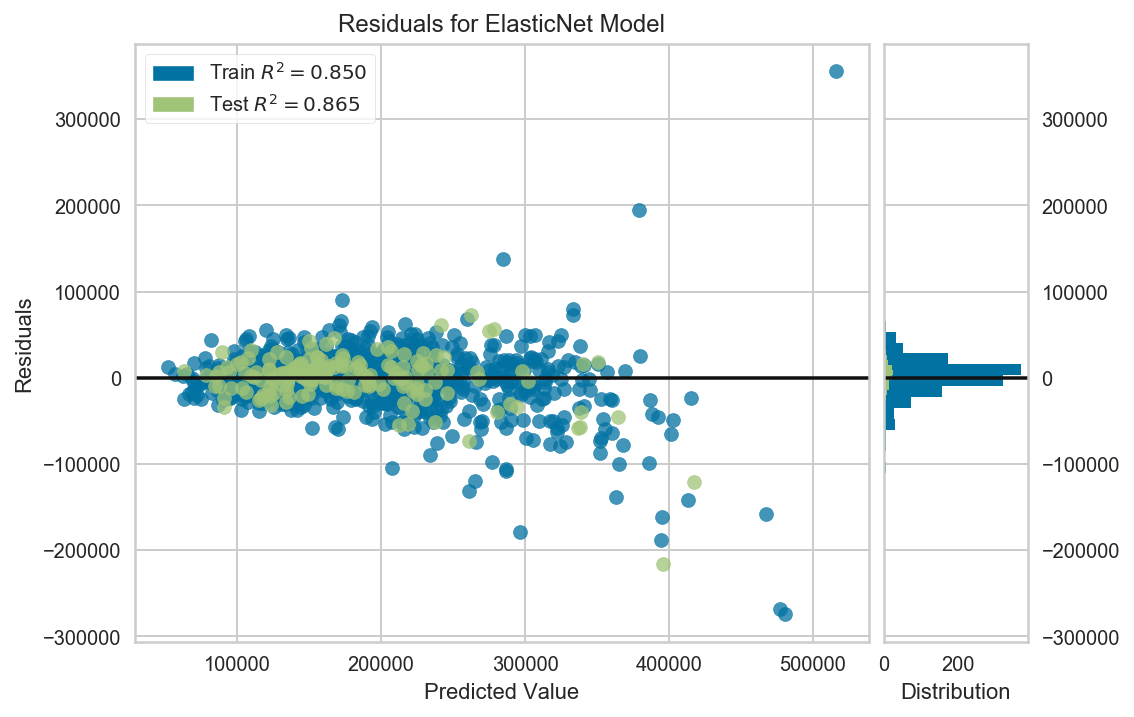

In [26]:
from sklearn.linear_model import ElasticNet
from yellowbrick.regressor import ResidualsPlot

enet1 = ElasticNet()
visualizerR = ResidualsPlot(enet1)

visualizerR.fit(X_trainFFs,np.exp(y_trainFF))
visualizerR.score(X_testFFs,np.exp(y_testFF))
visualizerR.poof()

In [27]:
# assigning train set residuals to y_trainRF (renovatable features)

enet_trainFF.fit(X_trainFFs,y_trainFF)

y_trainFF_pred = enet_trainFF.predict(X_trainFFs)
y_trainRF = np.exp(y_trainFF) - np.exp(y_trainFF_pred)

print(y_trainRF.shape)

(1278,)


In [28]:
# assigning test set residuals to y_testRF (renovatable features)

enet_testFF.fit(X_testFFs,y_testFF)

y_testFF_pred = enet_testFF.predict(X_testFFs)
y_testRF = np.exp(y_testFF) - np.exp(y_testFF_pred)

print(y_testRF.shape)

(172,)


---
#### Train test split for predictor variables (renovatable features)

In [29]:
# create dummy variables for renovatable categorical columns (23) +YrSold
# & combine with renovatable integer column (1)

renov_dummy_var = ['OverallQual','RoofStyle','RoofMatl',\
                   'Exterior1st','Exterior2nd','MasVnrType','ExterQual',\
                   'ExterCond','BsmtCond','BsmtFinType1','BsmtFinType2',\
                   'Heating','HeatingQC','CentralAir','Electrical',\
                   'KitchenQual','Fireplaces','FireplaceQu','YrSold',\
                   'GarageFinish','GarageQual','GarageCond','PoolQC',\
                   'Fence']

df_renov = df[['MasVnrArea']].copy()

for i in renov_dummy_var:
    print('Categories in {}: '.format(i), df[i].unique())
    dummies = pd.get_dummies(df[i], prefix='{}_'.format(i))
    dummies.drop(dummies.columns[len(dummies.columns)-1], axis=1,\
                 inplace=True)
    print('Dummy variables for {}: '.format(i), dummies.columns)
    df_renov = pd.concat([df_renov,dummies],axis=1)

Categories in OverallQual:  ['7' '6' '8' '5' '9' '4' '10' '3' '1' '2']
Dummy variables for OverallQual:  Index(['OverallQual__1', 'OverallQual__10', 'OverallQual__2', 'OverallQual__3',
       'OverallQual__4', 'OverallQual__5', 'OverallQual__6', 'OverallQual__7',
       'OverallQual__8'],
      dtype='object')
Categories in RoofStyle:  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
Dummy variables for RoofStyle:  Index(['RoofStyle__Flat', 'RoofStyle__Gable', 'RoofStyle__Gambrel',
       'RoofStyle__Hip', 'RoofStyle__Mansard'],
      dtype='object')
Categories in RoofMatl:  ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Dummy variables for RoofMatl:  Index(['RoofMatl__ClyTile', 'RoofMatl__CompShg', 'RoofMatl__Membran',
       'RoofMatl__Metal', 'RoofMatl__Roll', 'RoofMatl__Tar&Grv',
       'RoofMatl__WdShake'],
      dtype='object')
Categories in Exterior1st:  ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'S

In [30]:
# dataframe with all renovatable features

print(df_renov.info())
df_renov.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 128 entries, MasVnrArea to Fence__MnWw
dtypes: float64(1), uint8(127)
memory usage: 202.5 KB
None


(1450, 128)

In [31]:
# estimating the size of train & test sets
df.groupby(['YrSold'])['Id'].count()

YrSold
2006    312
2007    328
2008    302
2009    336
2010    172
Name: Id, dtype: int64

In [32]:
# set X_train (renovatable features) to pre-2010 housing data

X_trainRF = df_renov.drop(df_fixed[(df_fixed['YrSold__2006']==0)\
                  & (df_fixed['YrSold__2007']==0)\
                  & (df_fixed['YrSold__2008']==0)\
                  & (df_fixed['YrSold__2009']==0)].index)

X_trainRF.drop(columns=['YrSold__2006','YrSold__2007','YrSold__2008',\
                        'YrSold__2009'],inplace=True)

print(X_trainRF.shape)
print(y_trainRF.shape)

(1278, 124)
(1278,)


In [33]:
# set X_test (renovatable features) to 2010 housing data

X_testRF = df_renov[(df_fixed['YrSold__2006']==0)\
                  & (df_fixed['YrSold__2007']==0)\
                  & (df_fixed['YrSold__2008']==0)\
                  & (df_fixed['YrSold__2009']==0)]

X_testRF.drop(columns=['YrSold__2006','YrSold__2007','YrSold__2008',\
                       'YrSold__2009'],inplace=True)

print(X_testRF.shape)
print(y_testRF.shape)

(172, 124)
(172,)


---
### fit train set, apply StandardScaler to train & test, then model regressions

In [34]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_trainRFs = ss.fit_transform(X_trainRF)
X_testRFs = ss.transform(X_testRF)

print(X_trainRFs.shape)
print(X_testRFs.shape)

(1278, 124)
(172, 124)


In [35]:
# local regression variables (linreg,ridge,lasso,enet) for train set

linreg_trainRF, ridge_trainRF, lasso_trainRF, enet_trainRF = \
        all_regressions(X_trainRFs,y_trainRF,X_trainRF)

average linreg R^2:  -2.0792378401840412e+27
top 10 linreg coefficients:                variable          coef      abs_coef
111     GarageQual__TA  1.716752e+17  1.716752e+17
108     GarageQual__Fa  1.051225e+17  1.051225e+17
106  GarageFinish__Unf -1.021552e+17  1.021552e+17
116     GarageCond__TA -1.020512e+17  1.020512e+17
105  GarageFinish__RFn -9.388939e+16  9.388939e+16
104  GarageFinish__Fin -8.907129e+16  8.907129e+16
71   BsmtFinType1__Unf -6.135230e+16  6.135230e+16
68   BsmtFinType1__GLQ -6.014527e+16  6.014527e+16
109     GarageQual__Gd  5.813735e+16  5.813735e+16
113     GarageCond__Fa -5.569864e+16  5.569864e+16


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.....................................................................................................................................................................................................................................................................................................................

optimal ridge alpha:  1389.4954943731389
average ridgereg R^2:  0.11264882385227817
top 10 ridgereg coefficients:                   variable         coef     abs_coef
15      RoofMatl__ClyTile -8400.724047  8400.724047
93        KitchenQual__Ex  2350.485539  2350.485539
119            PoolQC__Gd -2268.197003  2268.197003
98          Fireplaces__2  2111.732888  2111.732888
107        GarageQual__Ex  1612.162332  1612.162332
25   Exterior1st__BrkFace  1505.991390  1505.991390
55          ExterQual__Ex  1359.499825  1359.499825
9          OverallQual__8  1298.699301  1298.699301
117            PoolQC__Ex  1215.109313  1215.109313
96          Fireplaces__0 -1076.987605  1076.987605


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

optimal lasso alpha:  2107.303382780729
average lassoreg R^2:  0.11782699535698422
top 10 lassoreg coefficients:                   variable          coef      abs_coef
15      RoofMatl__ClyTile -17118.810869  17118.810869
93        KitchenQual__Ex   4824.808041   4824.808041
98          Fireplaces__2   2637.907859   2637.907859
25   Exterior1st__BrkFace   1677.137003   1677.137003
2         OverallQual__10   1667.182153   1667.182153
9          OverallQual__8   1623.942110   1623.942110
96          Fireplaces__0  -1365.870595   1365.870595
55          ExterQual__Ex   1237.781766   1237.781766
107        GarageQual__Ex    863.293803    863.293803
83          HeatingQC__Ex    691.868087    691.868087
optimal enet alpha:  2125.0343197466755
optimal enet l1_ratio:  1.0
average enetreg R^2:  0.11762354658436683
top 10 Enetreg coefficients:                   variable          coef      abs_coef
15      RoofMatl__ClyTile -17096.272821  17096.272821
93        KitchenQual__Ex   4824.635404   48

In [36]:
# local regression variables (linreg,ridge,lasso,enet) for test set

linreg_testRF, ridge_testRF, lasso_testRF, enet_testRF = \
        all_regressions(X_testRFs,y_testRF,X_testRF)

average linreg R^2:  -3.9128697903420916e+28
top 10 linreg coefficients:               variable          coef      abs_coef
16  RoofMatl__CompShg -3.570045e+18  3.570045e+18
15  RoofMatl__ClyTile -2.220172e+18  2.220172e+18
21  RoofMatl__WdShake -1.272726e+18  1.272726e+18
3      OverallQual__2 -8.810012e+17  8.810012e+17
20  RoofMatl__Tar&Grv -8.496913e+17  8.496913e+17
10    RoofStyle__Flat -7.640756e+17  7.640756e+17
19     RoofMatl__Roll -6.792921e+17  6.792921e+17
2     OverallQual__10 -6.423268e+17  6.423268e+17
97      Fireplaces__1 -6.142670e+17  6.142670e+17
58      ExterCond__Ex  5.739469e+17  5.739469e+17


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
..................................................................................................................................................................................................

optimal ridge alpha:  596.3623316594649
average ridgereg R^2:  0.03484225893583263
top 10 ridgereg coefficients:                   variable         coef     abs_coef
55          ExterQual__Ex  1533.671624  1533.671624
93        KitchenQual__Ex  1343.879225  1343.879225
104     GarageFinish__Fin   840.072835   840.072835
54      MasVnrType__Stone   679.671678   679.671678
0              MasVnrArea   651.135479   651.135479
98          Fireplaces__2   629.872944   629.872944
11       RoofStyle__Gable  -544.029530   544.029530
13         RoofStyle__Hip   533.951625   533.951625
25   Exterior1st__BrkFace   505.459400   505.459400
31   Exterior1st__Plywood  -494.312811   494.312811


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

optimal lasso alpha:  1951.762683539169
average lassoreg R^2:  0.016055897000876916
top 10 lassoreg coefficients:                   variable         coef     abs_coef
93        KitchenQual__Ex  4409.823646  4409.823646
55          ExterQual__Ex  3964.060784  3964.060784
104     GarageFinish__Fin  1659.604976  1659.604976
54      MasVnrType__Stone   580.711971   580.711971
98          Fireplaces__2   404.542272   404.542272
4          OverallQual__3  -297.357565   297.357565
25   Exterior1st__BrkFace   106.533970   106.533970
122          Fence__MnPrv    65.670684    65.670684
31   Exterior1st__Plywood   -42.539136    42.539136
90      Electrical__FuseP     0.000000     0.000000
optimal enet alpha:  1818.6805237320348
optimal enet l1_ratio:  1.0
average enetreg R^2:  0.010159098658989184
top 10 Enetreg coefficients:                   variable         coef     abs_coef
93        KitchenQual__Ex  4485.268044  4485.268044
55          ExterQual__Ex  4007.802678  4007.802678
104     GarageFi

In [37]:
# determine residuals for y_testRF (renovatable features)
lasso_trainRF.fit(X_trainRFs,y_trainRF)

y_trainRF_pred = lasso_trainRF.predict(X_trainRFs)
y_trainRF_resid = y_trainRF - y_trainRF_pred

y_trainRF_resid.mean()

-4.447841851393428e-14

In [38]:
# determine residuals for y_testRF (renovatable features)
lasso_testRF.fit(X_testRFs,y_testRF)

y_testRF_pred = lasso_testRF.predict(X_testRFs)
y_testRF_resid = y_testRF - y_testRF_pred

y_testRF_resid.mean()

-1.142156137110189e-12

---
### Preliminary conclusion:

**2a**. Evaluate the effect in dollars of the renovatable features. 

**Answer**: 

- The average (mean) residual values for the train and test (renovatable features) datasets are slightly negative (-1.14x10^-12, -4.47x10^-14) but tend towards 0.
- This indicates that the model's prediction of the target variable is relatively similar to the actual target variable values (i.e. residuals of fixed feature ridge regression). 

In [39]:
# effect of renovatable features from test set on sale price

print('Effect of renovatable features on SalePrice: ${}'.\
      format(round(y_testRF_pred.mean(),2)))

Effect of renovatable features on SalePrice: $2033.15


---
**2b**. How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 

**Answer**:
- The company can use this second model to determine which renovatable features can <font color=red>better predict a house's sale price beyond its fixed features</font>.
- The model's coefficients provide an estimation of <font color=red>the marginal change in sale price relative to a change in the predictor variable</font>.
- This will help the company <font color=red>better prioritize the order of renovations</font> based on which features will have the largest predicted impact on the sale price.
- The coefficients also help the company <font color=red>decide if the renovation of a feature is profitable</font> (by comparing its predicted value-add with its renovation cost).
- The company can use both models to <font color=red>quickly filter potential houses</font>, first by examining if a house has the top 10/20 fixed features (top 10/20 coefficients of model 1) and then determining if the house has the top 10/20 renovatable features (top 10/20 coefficients of model 2).

---

- The best model to use is Lasso Regression

**Train set (pre-2010 housing data)**:
- average $R^2$ of <font color=red>0.117826</font>
- <font color=red>top 10 best estimators of price</Font> (in descending order): 
    1. **RoofMatl__ClyTile** - Roof material (Clay or Tile)
    2. **KitchenQual__Ex** - Excellent kitchen quality
    3. **Fireplaces__2** - Number of fireplaces = 2
    4. **Exterior1st__BrkFace** - Exterior covering house is Brick Face
    5. **OverallQual__10** - Very Excellent overall material & finish of house
    6. **OverallQual__8** - Very Good overall material & finish of house
    7. **Fireplaces__0** - No fireplaces
    8. **ExterQual__Ex** - Excellent quality of material on the house exterior
    9. **GarageQual__Ex** - Excellent garage quality
    10. **HeatingQC__Ex** - Excellent heating quality and condition

**Test set (2010 housing data)**:
- average $R^2$ of <font color=red>0.016055</font>
- <font color=red>top 9 best estimators of price</Font> (in descending order):
    1. **KitchenQual__Ex** - Excellent kitchen quality
    2. **ExterQual__Ex** - Excellent quality of material on the house exterior
    3. **GarageFinish__Fin** - Finished interior of garage
    4. **MasVnrType__Stone** - Masonry veneer type is stone
    5. **Fireplaces__2** - Number of fireplaces = 2
    6. **OverallQual__3** - Fair overall material & finish of house
    7. **Exterior1st__BrkFace** - Exterior covering house is Brick Face
    8. **Fence__MnPrv** - Fence with minimum privacy
    9. **Exterior1st__Plywood** - Exterior covering house is Plywood
---

---
**2c**. Investigate how much of the variance in price remaining is explained by these features.

**Answer**:

Based on the top 10 variables from the test set results:
- the <font color=red>target variable</font> is the variance in price remaining unexplained by the house's fixed features

    1. a unit change in KitchenQual__Ex (Excellent kitchen quality) will change the <font color=red>target variable</font> by 4485 units.
    2. a unit change in ExterQual__Ex (Excellent house exterior material quality) will change the <font color=red>target variable</font> by 4007 units.
    3. a unit change in GarageFinish__Fin (Finished garage interior) will change the <font color=red>target variable</font> by 1733 units.
    4. a unit change in MasVnrType__Stone (Stone masonry veneer) will change the <font color=red>target variable</font> by 644 units.
    5. a unit change in Fireplaces__2 (having 2 fireplaces) will change the <font color=red>target variable</font> by 470 units.
    6. a unit change (increase/decrease) in OverallQual__3 (Fair overall material & finish of house) will have an inverse change (decrease/increase) of 371 units on the <font color=red>target variable</font>.
    7. a unit change in Exterior1st__BrkFace (brick face covering house exterior) will change the <font color=red>target variable</font> by 147 units.
    8. a unit change in Fence__MnPrv (fence with minimum privacy) will change the <font color=red>target variable</font> by 182 units.
    9. a unit change (increase/decrease) in the Exterior1st__Plywood (plywood covering house exterior) will have an inverse change (decrease/increase) of 140 units on the <font color=red>target variable</font>.

---
**2d**. Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

**Answer**:

- The $R^2$ score for the test set in model 1 is relatively good at 0.85721, although the $R^2$ score for the test set in model 2 is relatively poor at 0.016055.
- I would recommend <font color=red>using model 1 to filter potential houses based on their fixed features</font> and then further vary the 'renovatable' features (variables) included model 2 to obtain a better $R^2$ score.
- It would also be interesting to <font color=red>compare the change in top 10 fixed and renovatable features (variables) between the train and test data sets</font>, to <font color=purple>identify any underlying shifts in property buyers' expectations</font>.
---

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [40]:
# create dummy variables for sales columns

sales_dummy_var = ['SaleType','SaleCondition']

df_sales = df[['Id']].copy()

for i in sales_dummy_var:
    print('Categories in {}: '.format(i), df[i].unique())
    dummy = pd.get_dummies(df[i], prefix='{}_'.format(i))
    dummy.drop(dummy.columns[len(dummy.columns)-1],axis=1,inplace=True)
    print('Dummy variables for {}: '.format(i), dummy.columns)
    df_sales = pd.concat([df_sales,dummy],axis=1)

Categories in SaleType:  ['WD' 'New' 'COD' 'ConLI' 'CWD' 'ConLw' 'Con' 'ConLD' 'Oth']
Dummy variables for SaleType:  Index(['SaleType__COD', 'SaleType__CWD', 'SaleType__Con', 'SaleType__ConLD',
       'SaleType__ConLI', 'SaleType__ConLw', 'SaleType__New', 'SaleType__Oth'],
      dtype='object')
Categories in SaleCondition:  ['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']
Dummy variables for SaleCondition:  Index(['SaleCondition__Abnorml', 'SaleCondition__AdjLand',
       'SaleCondition__Alloca', 'SaleCondition__Family',
       'SaleCondition__Normal'],
      dtype='object')


In [41]:
# dataframe with sales columns

print(df_sales.info())
df_sales.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 14 columns):
Id                        1450 non-null int64
SaleType__COD             1450 non-null uint8
SaleType__CWD             1450 non-null uint8
SaleType__Con             1450 non-null uint8
SaleType__ConLD           1450 non-null uint8
SaleType__ConLI           1450 non-null uint8
SaleType__ConLw           1450 non-null uint8
SaleType__New             1450 non-null uint8
SaleType__Oth             1450 non-null uint8
SaleCondition__Abnorml    1450 non-null uint8
SaleCondition__AdjLand    1450 non-null uint8
SaleCondition__Alloca     1450 non-null uint8
SaleCondition__Family     1450 non-null uint8
SaleCondition__Normal     1450 non-null uint8
dtypes: int64(1), uint8(13)
memory usage: 41.1 KB
None


(1450, 14)